In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage

col_names=['ch1','ch2','ch3','ch4']
gesture_names = ['Rest','Extension','Flexion','UlnarDeviation','RadialDeviation','Grip','AbductionOfFingers','AdductionOfFingers','Supination','Pronation']

Reshape the data1~data40 to 3-D arrays having gesture names

In [2]:
import warnings
warnings.filterwarnings('ignore') # too many warnings (use DataFrame.transpose instead of DataFrame.swapaxes)
c=0
for i in range(40): # data1 to data40
    globals()['data{}'.format(i+1)] = pd.read_csv('/Users/jhr/workspace/GitHub/EMG_data_analysis/Dataset for multi-channel surface electromyography (sEMG) signals of hand gestures/sEMG-dataset/raw/csv/{}_raw.csv'.format(i+1), names=col_names)

    globals()['data{}_patterns'.format(i+1)] = [globals()['data{}'.format(i+1)][r:r + 268000] for r in range(0, len(globals()['data{}'.format(i+1)]), 268000)] #divide the data by 268000 steps at a time

    for j in range(5): # pattern1 to pattern5
        globals()['data{}_gestures{}'.format(i+1,j+1)] = np.array_split(globals()['data{}_patterns'.format(i+1)][j].iloc[4000:204000], 10) #split the data into 10 gestures
        
        for g in range(10): # gesture1 to gesture10
            if i==0: # make a array, the first face of 3-D gesture array
                globals()['{}_signal'.format(gesture_names[g])] = globals()['data{}_gestures{}'.format(i+1,j+1)][g].reset_index(drop=True).to_numpy()[np.newaxis,:] # 3-D arrays after numpy.newaxis having gesture names 
                
            else: # vertically stack the 2-D arrays to the previously generated 3-D array
                globals()['{}_signal'.format(gesture_names[g])] = np.vstack([globals()['{}_signal'.format(gesture_names[g])],globals()['data{}_gestures{}'.format(i+1,j+1)][g].reset_index(drop=True).to_numpy()[np.newaxis,:]])

        c+=1
        #print('i:{} j:{} c:{}'.format(i+1,j+1,c))

In [3]:
# check the shape of the 3-D arrays
Extension_signal.shape # but why (196, 20000, 4) ?

(196, 20000, 4)

Filtering

1. Define some filters to go through

In [4]:
def maximum(raw, box_size, mode='nearest'): # Maximum filter
    raw_maximum=ndimage.maximum_filter(raw,box_size,mode=mode)
    return raw_maximum.real

def denoise_fft(data, ifftn): # Fast Fourier Transformation denoiser
    # apply the FFT
    fft_signal = np.fft.fft(data)
    
    # reconstruct the original signal by apply the IFFT
    fft_signal[ifftn:len(fft_signal)//2]=0
    fft_signal[len(fft_signal)//2:-ifftn]=0
    reconstructed_signal = np.fft.ifft(fft_signal)
    
    return reconstructed_signal.real

def smooth(x,beta): # Kaiser Window Smoothing technique
    window_len=11  # extend the data at beginning and at the end to apply the window at the borders

    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[5:len(y)-5]

2. Apply Filters

In [31]:
for i in range(196): # 196(?) samples
    for g in gesture_names: # 10 gestures
        for ch in range(4):
            if i == 0:
                globals()['{}_signal_filtered'.format(g)] = np.ndarray(globals()['{}_signal'.format(g)][:,2000:18000].shape) # make a array shape with a little rest time
                globals()['{}_signal_filtered'.format(g)][i][:,ch] = smooth(denoise_fft(maximum(globals()['{}_signal'.format(g)][i][:,ch],25),5),2)[2000:18000] # apply the filters and cut the rest time
                
            else:
                globals()['{}_signal_filtered'.format(g)][i][:,ch] = smooth(denoise_fft(maximum(globals()['{}_signal'.format(g)][i][:,ch],25),5),2)[2000:18000] # apply the filters and cut the rest time
                

3. Draw the filtered signals to overview

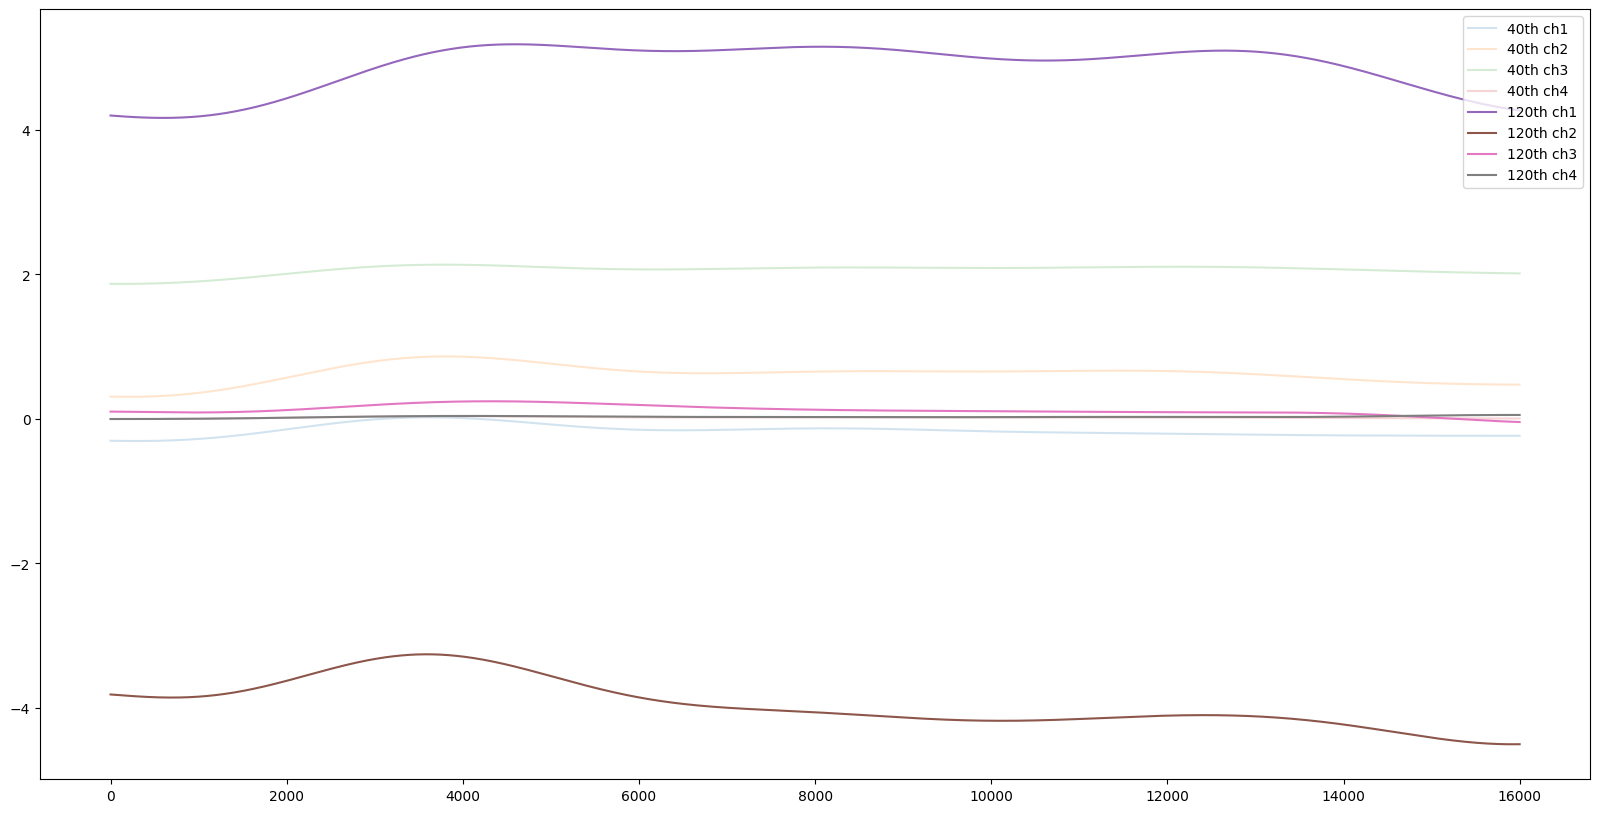

In [32]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(Extension_signal_filtered[40],label=['40th '+s for s in col_names],alpha=0.2)
ax.plot(Extension_signal_filtered[120],label=['120th '+s for s in col_names])

plt.legend()
plt.show()

    The signals of each channel show very similar shapes but different locations(y-axis)

In [7]:
# tasks to do :
# 1. find the best classifier for the same pattern but different range of values
#    (StandardScaler-standardization, MinMaxScaler-normalization,
#     PCA-dimensional reduction, t-SNE-dimensional reduction)
# 2. classify the data with varying time ranges 
#    ('Down-Scaling', 'Up-Scaling')
# 3. repeat classifying with different window sizes to get the best

Standardization and Normalization

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

standardscaler = StandardScaler()
minmaxscaler = MinMaxScaler()

1. StandardScaler - sets values have mean to 0 with standard deviation

In [29]:
X40_std = standardscaler.fit_transform(Extension_signal_filtered[40])
X80_std = standardscaler.fit_transform(Extension_signal_filtered[80])

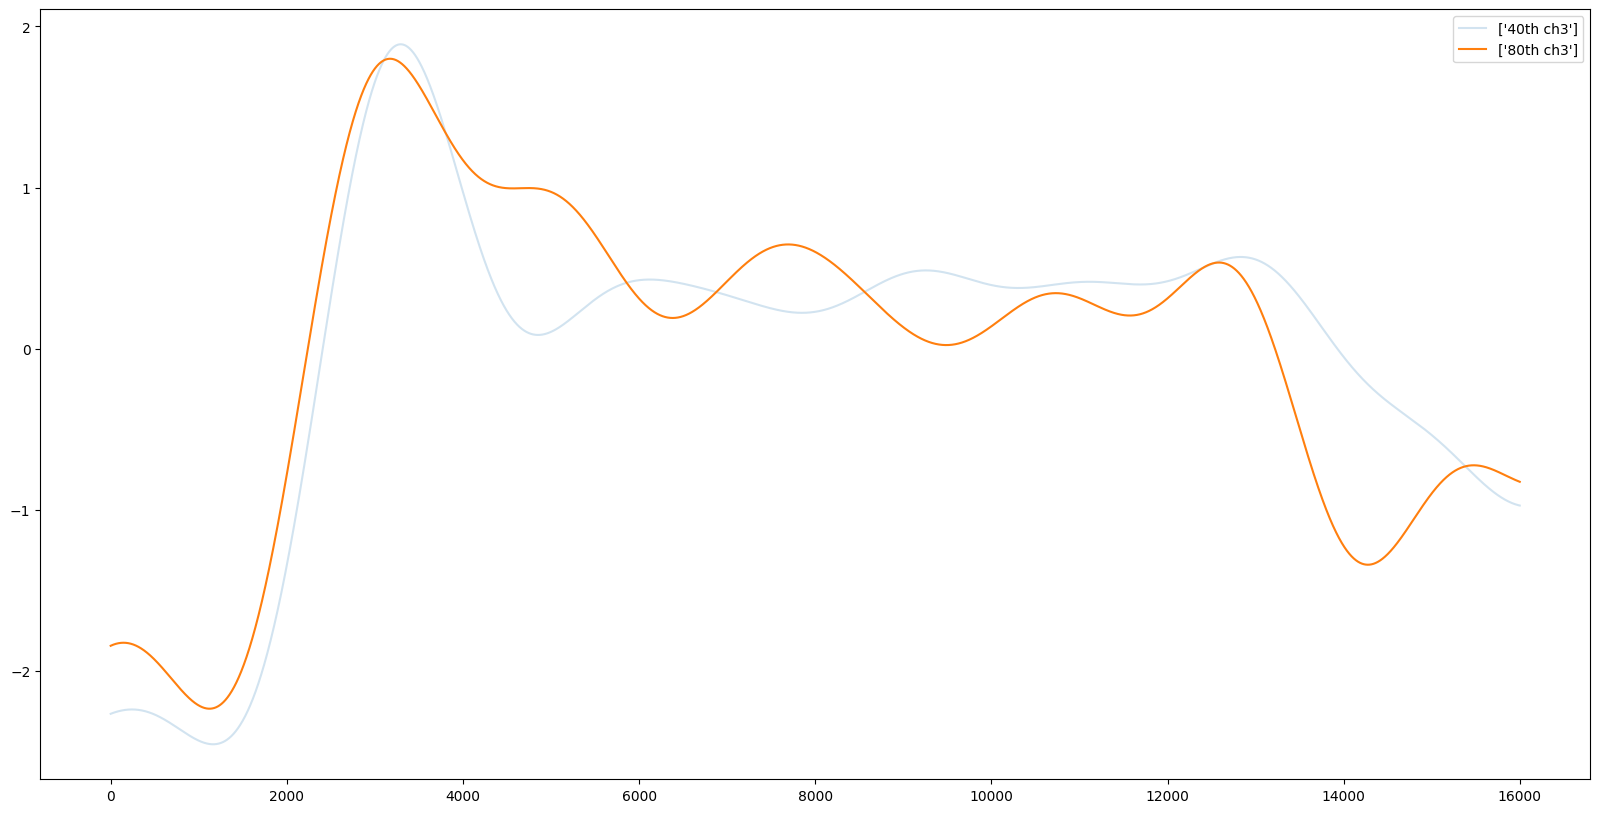

In [33]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(X40_std[:,2],label=['40th '+col_names[2]],alpha=0.2)
ax.plot(X80_std[:,2],label=['80th '+col_names[2]])

plt.legend()
plt.show()

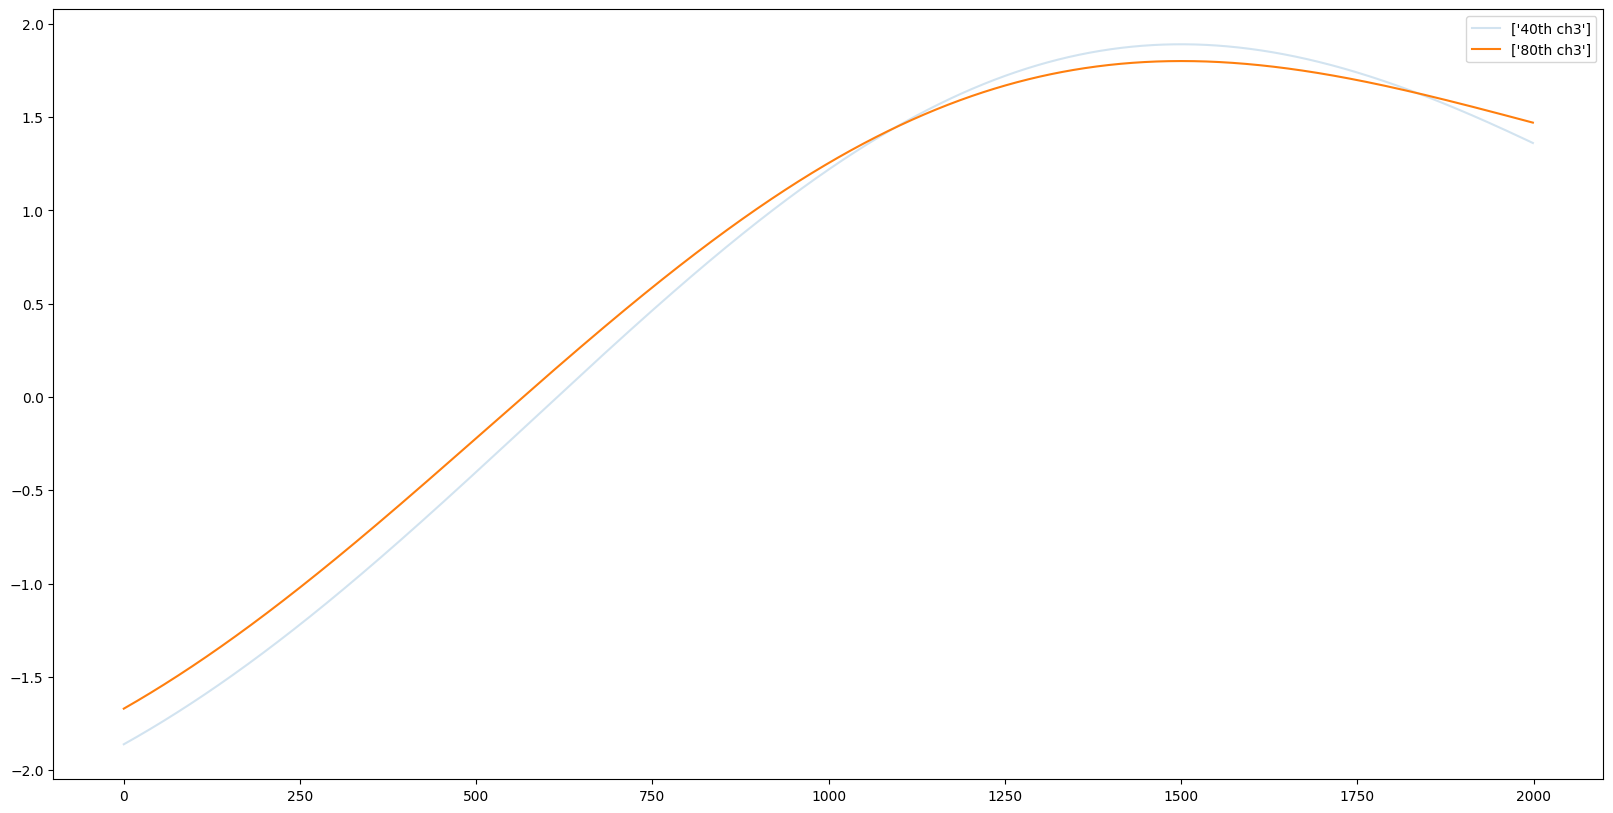

In [54]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
X40_std_cut = X40_std[np.where(X40_std[:,2]==np.max(X40_std[:,2]))[0][0]-1500:np.where(X40_std[:,2]==np.max(X40_std[:,2]))[0][0]+500,2]
X80_std_cut = X80_std[np.where(X80_std[:,2]==np.max(X80_std[:,2]))[0][0]-1500:np.where(X80_std[:,2]==np.max(X80_std[:,2]))[0][0]+500,2]
ax.plot(X40_std_cut,label=['40th '+col_names[2]],alpha=0.2)
ax.plot(X80_std_cut,label=['80th '+col_names[2]])

plt.legend()
plt.show()

2. MinMaxScaler - sets minimum signal to 0, maximum signal to 1, and other values between them

In [36]:
X40_mm = minmaxscaler.fit_transform(Extension_signal_filtered[40])
X80_mm = minmaxscaler.fit_transform(Extension_signal_filtered[80])

In [13]:
np.where(X80_mm[:,2]==np.max(X80_mm[:,2]))[0][0]

5200

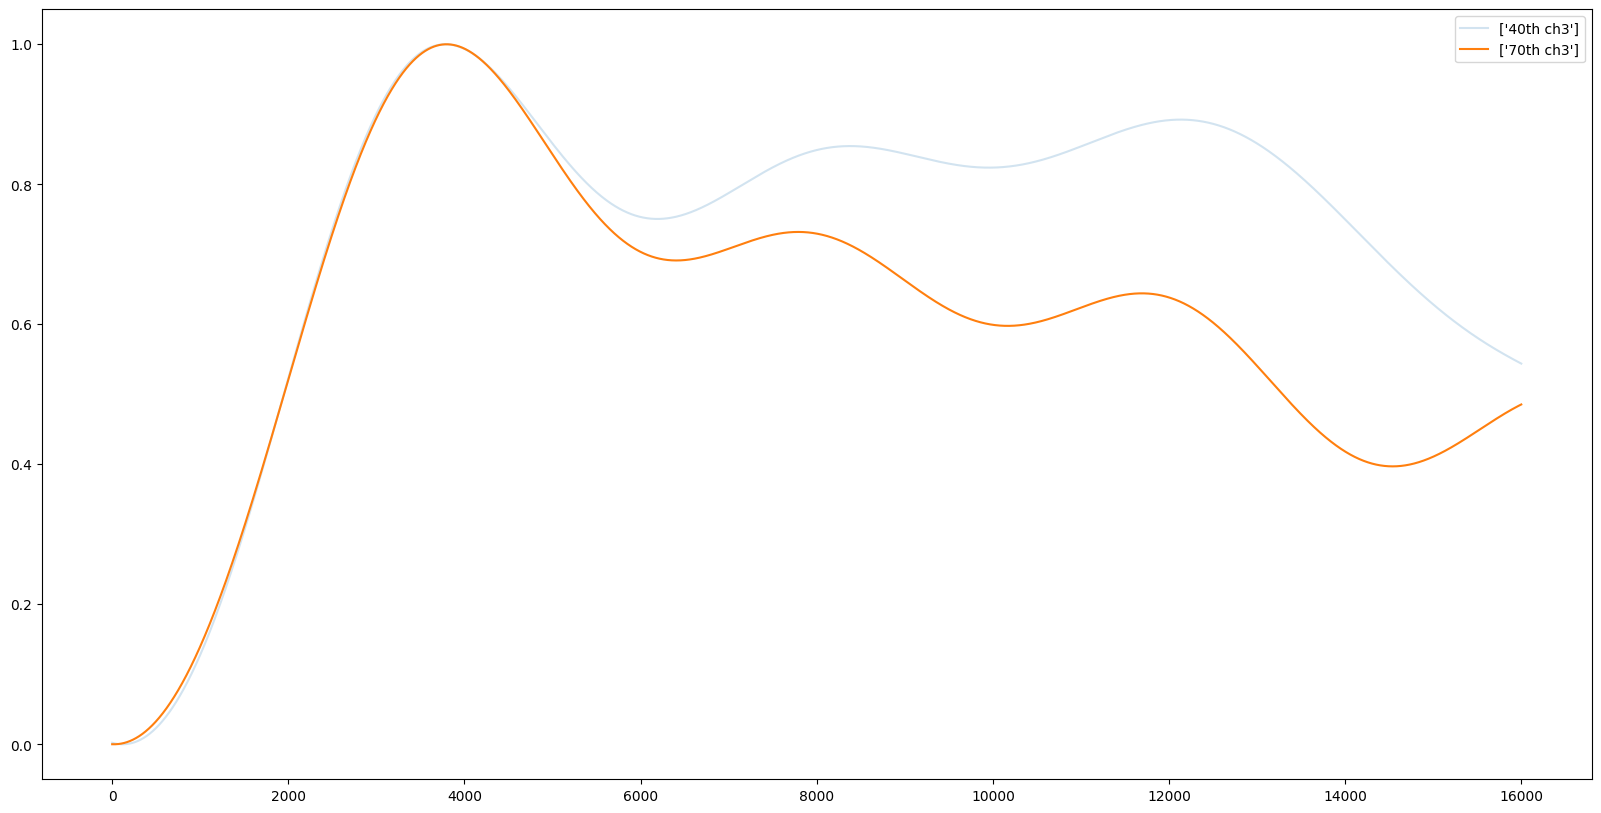

In [37]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(X40_mm[:,2],label=['40th '+col_names[2]],alpha=0.2)
ax.plot(X80_mm[:,2],label=['70th '+col_names[2]])

plt.legend()
plt.show()

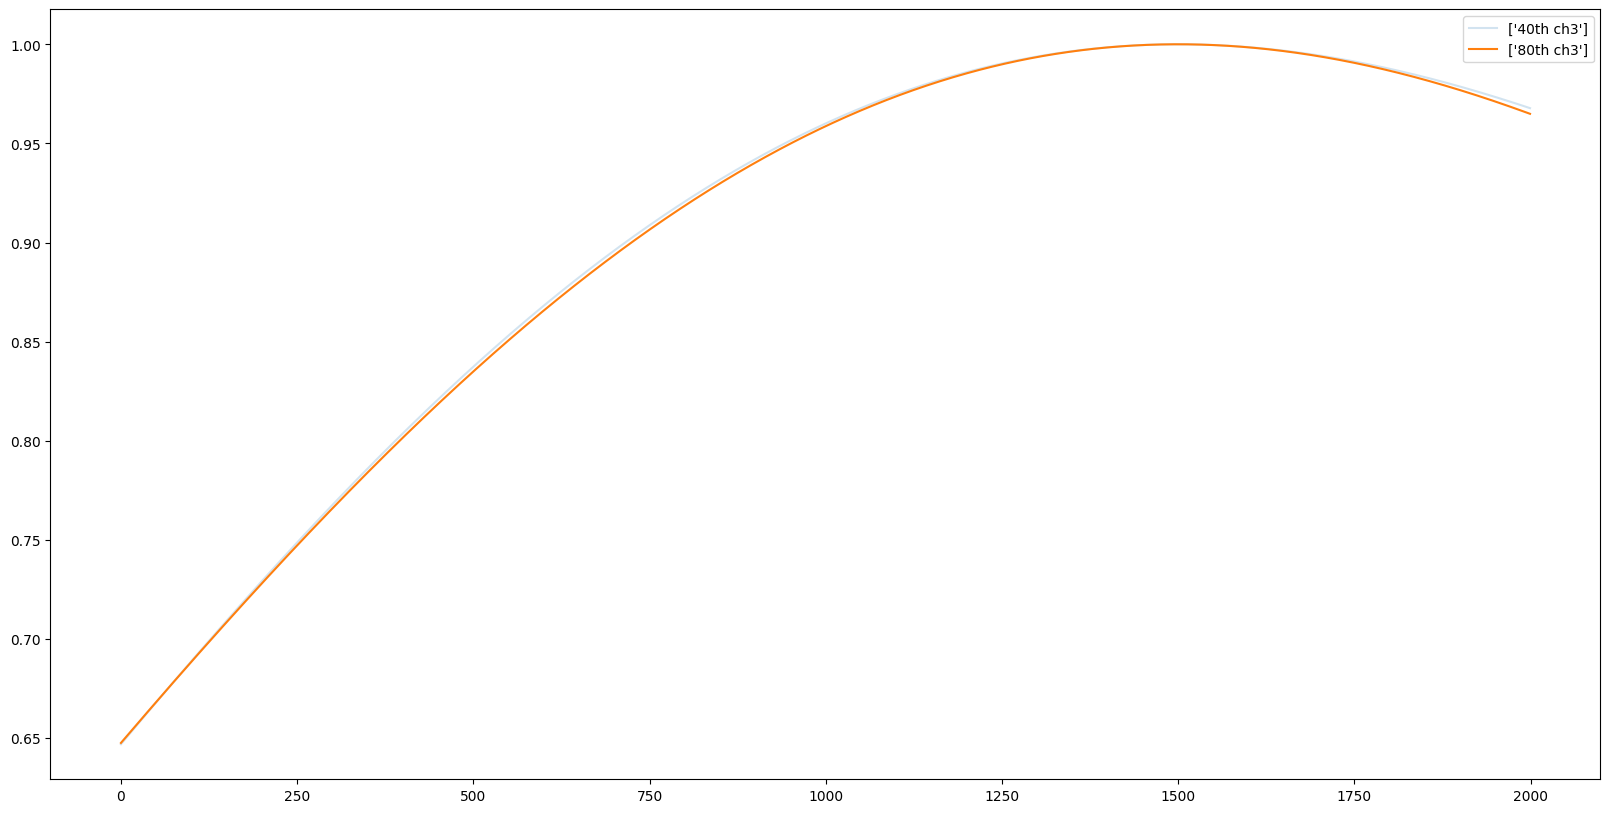

In [52]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(X40_mm[np.where(X40_mm[:,2]==np.max(X40_mm[:,2]))[0][0]-1500:np.where(X40_mm[:,2]==np.max(X40_mm[:,2]))[0][0]+500,2],label=['40th '+col_names[2]],alpha=0.2)
ax.plot(X80_mm[np.where(X80_mm[:,2]==np.max(X80_mm[:,2]))[0][0]-1500:np.where(X80_mm[:,2]==np.max(X80_mm[:,2]))[0][0]+500,2],label=['80th '+col_names[2]])

plt.legend()
plt.show()

3. MinMaxScaler after StandardScaler

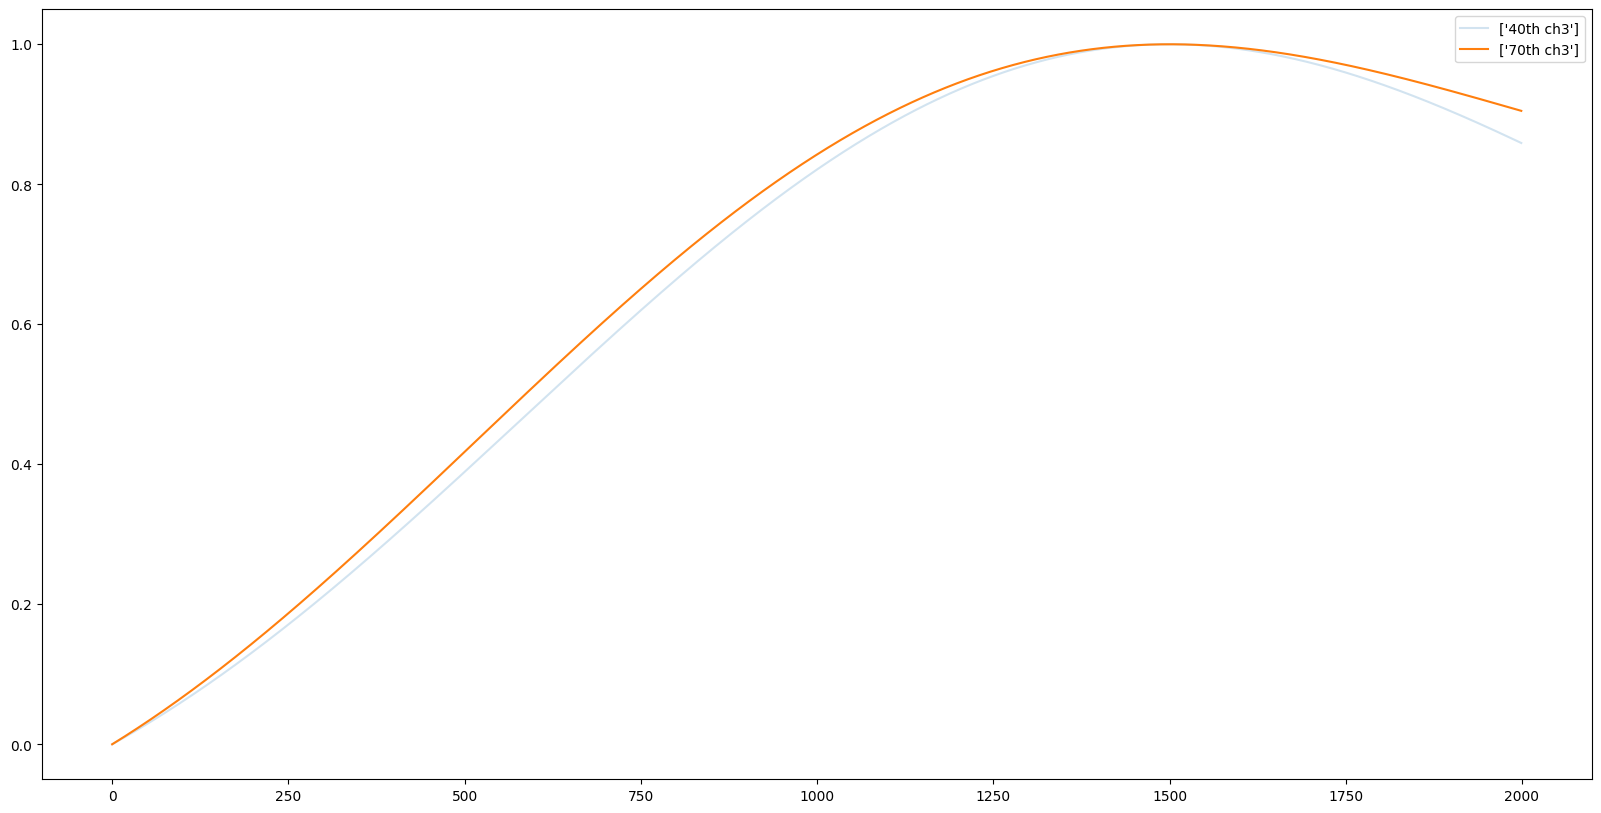

In [55]:
X40_std_mm = minmaxscaler.fit_transform(X40_std_cut.reshape(-1,1))
X80_std_mm = minmaxscaler.fit_transform(X80_std_cut.reshape(-1,1))


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(X40_std_mm,label=['40th '+col_names[2]],alpha=0.2)
ax.plot(X80_std_mm,label=['70th '+col_names[2]])

plt.legend()
plt.show()

Dimensionality Reduction

1. PCA(Principal Component Analysis) - find a new axis that has a maximum variance between it and the orthogonal vetors from the values (linear)

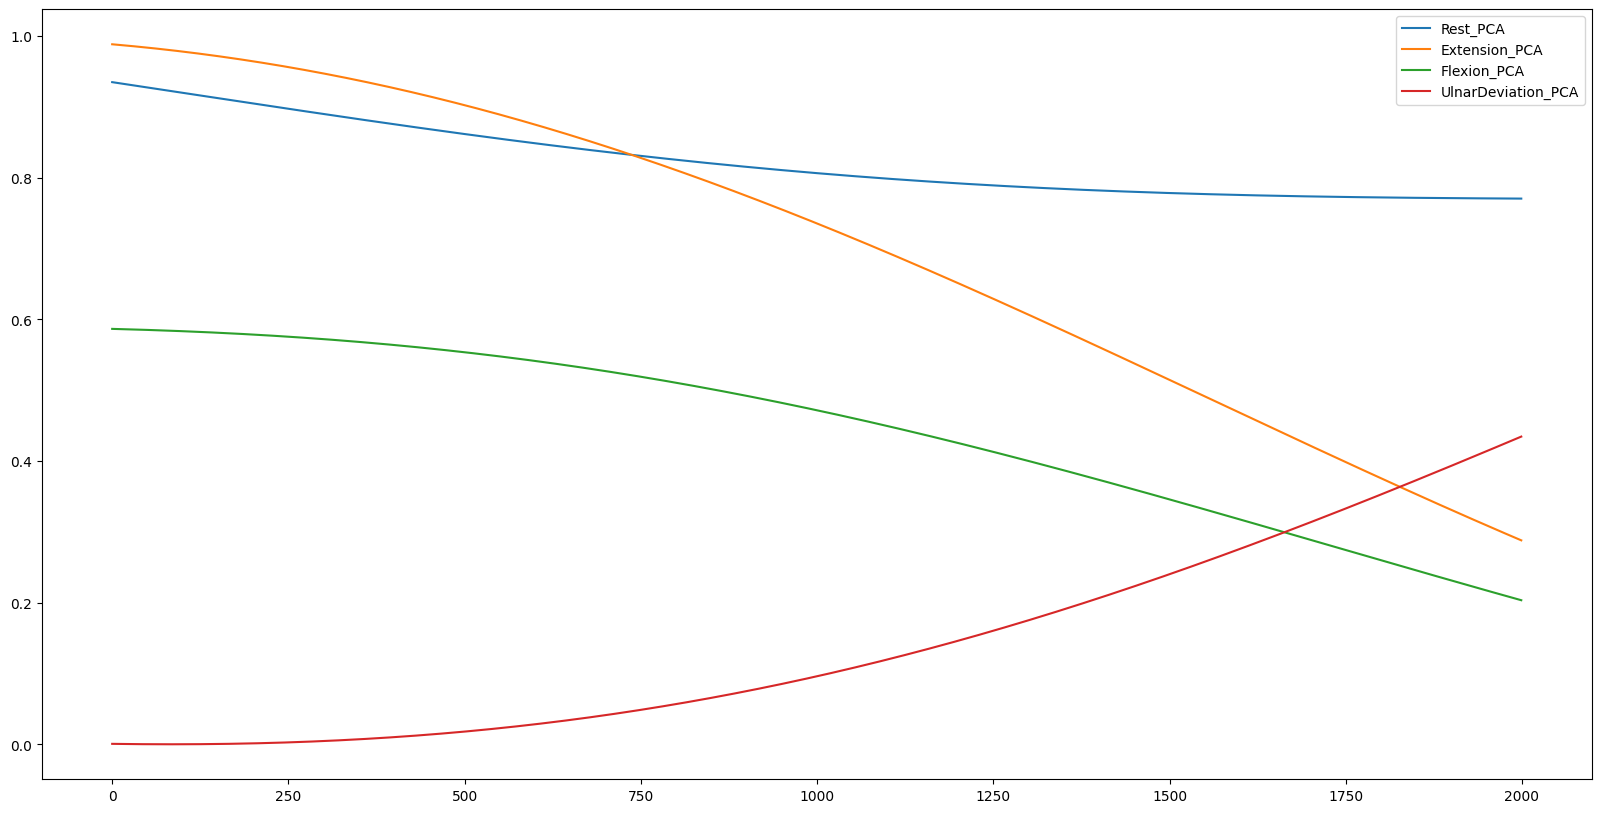

In [86]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_pca'.format(g)] = minmaxscaler.fit_transform(pca.fit_transform(standardscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][40])))[500:2500]
    ax.plot(globals()['{}_pca'.format(g)],label='{}_PCA'.format(g))

plt.legend()
plt.show()

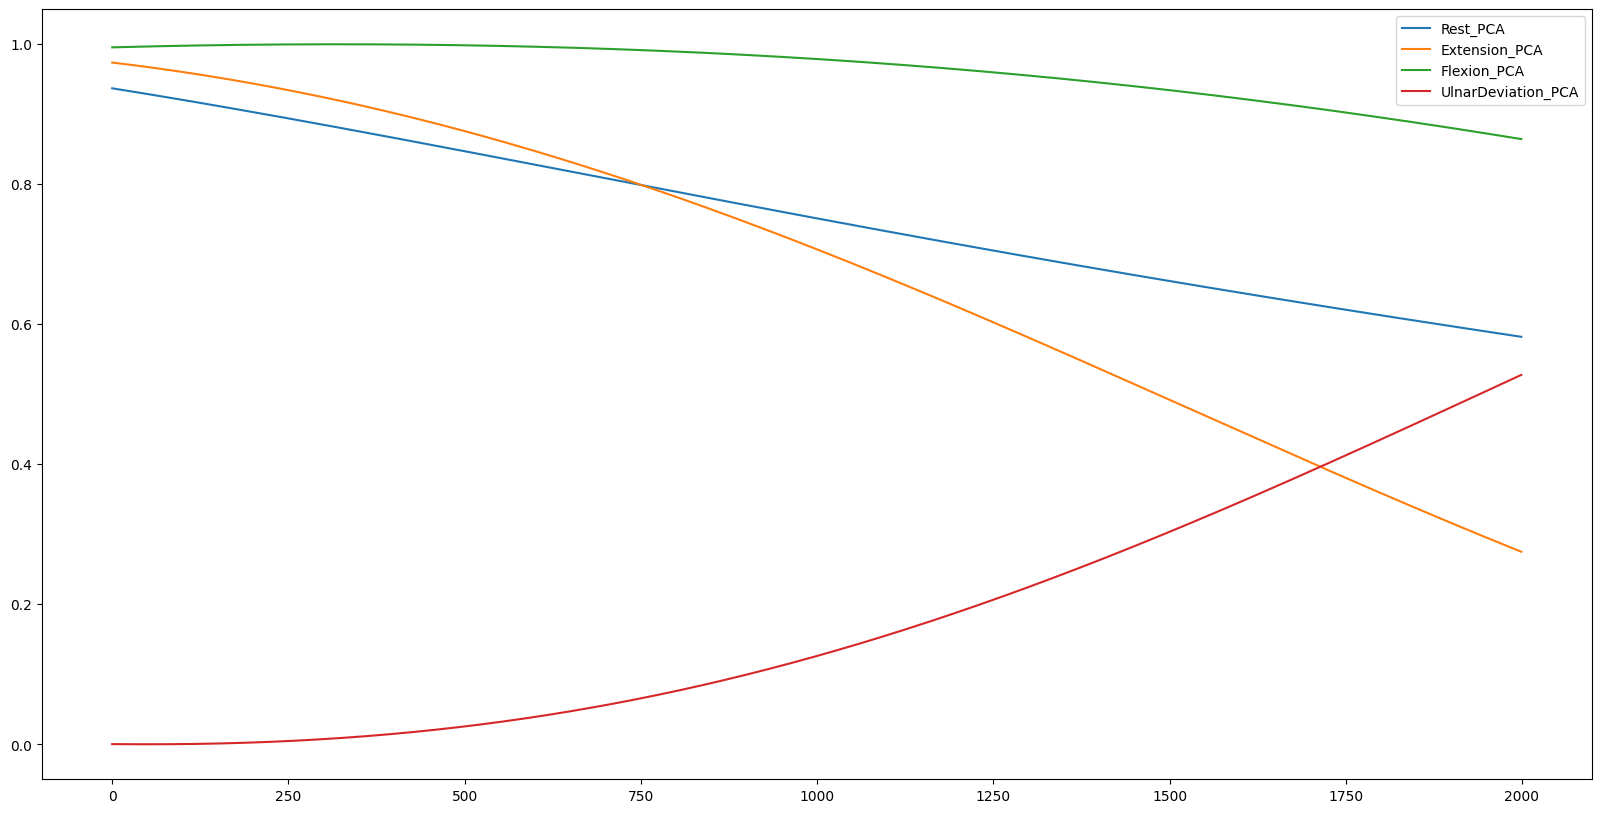

In [87]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_pca'.format(g)] = minmaxscaler.fit_transform(pca.fit_transform(standardscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][80])))[500:2500]
    ax.plot(globals()['{}_pca'.format(g)],label='{}_PCA'.format(g))

plt.legend()
plt.show()

2. Kernel PCA - a extension of the PCA using kernel methods

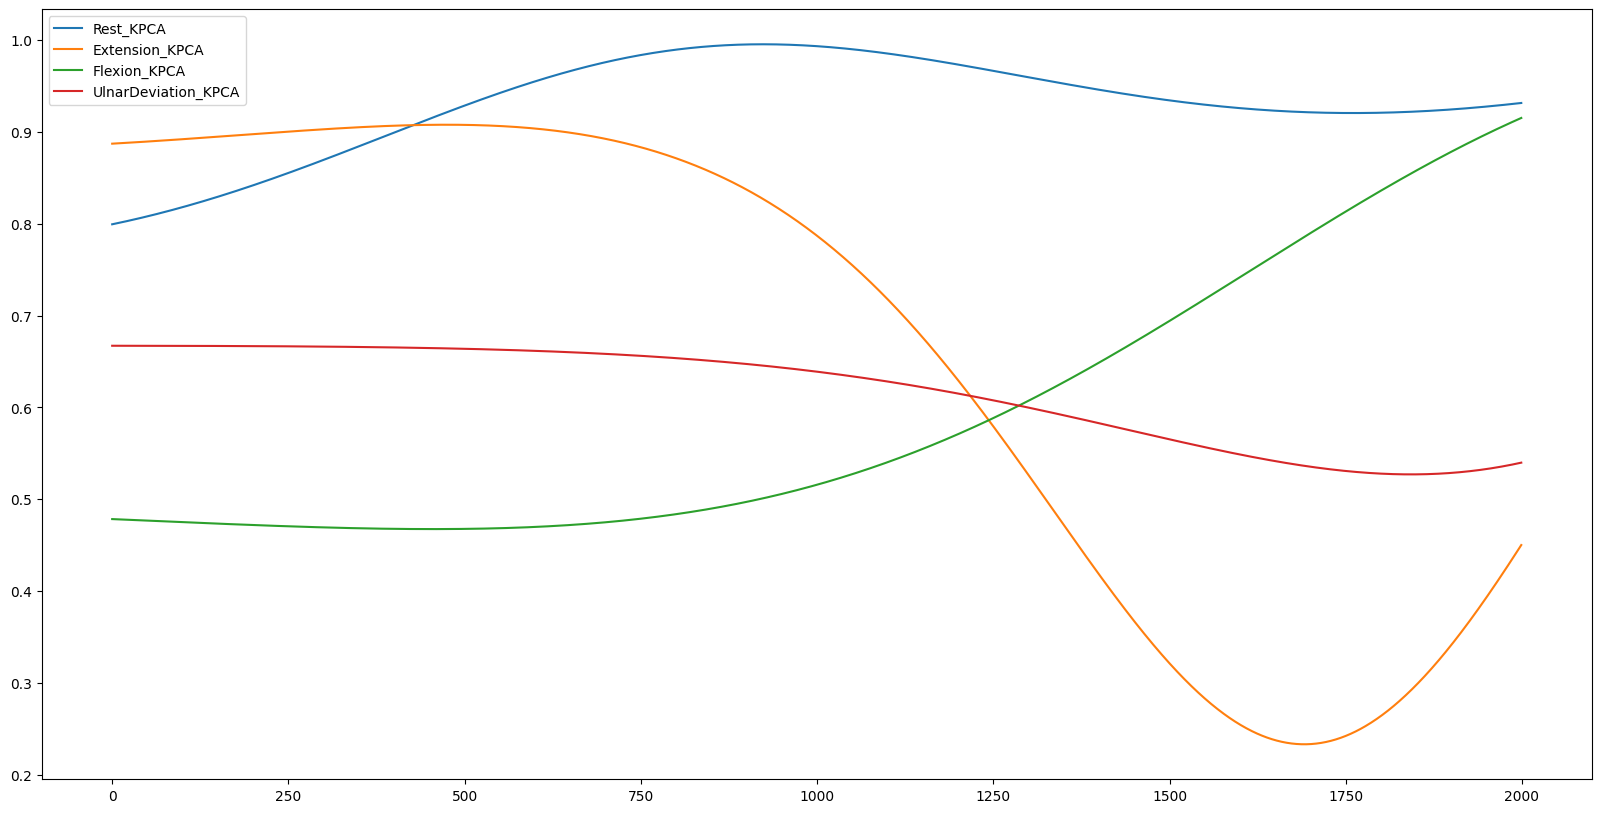

In [122]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=1, kernel='rbf')

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_kpca'.format(g)] = minmaxscaler.fit_transform(kpca.fit_transform(standardscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][40])))[500:2500]
    ax.plot(globals()['{}_kpca'.format(g)],label='{}_KPCA'.format(g))

plt.legend()
plt.show()

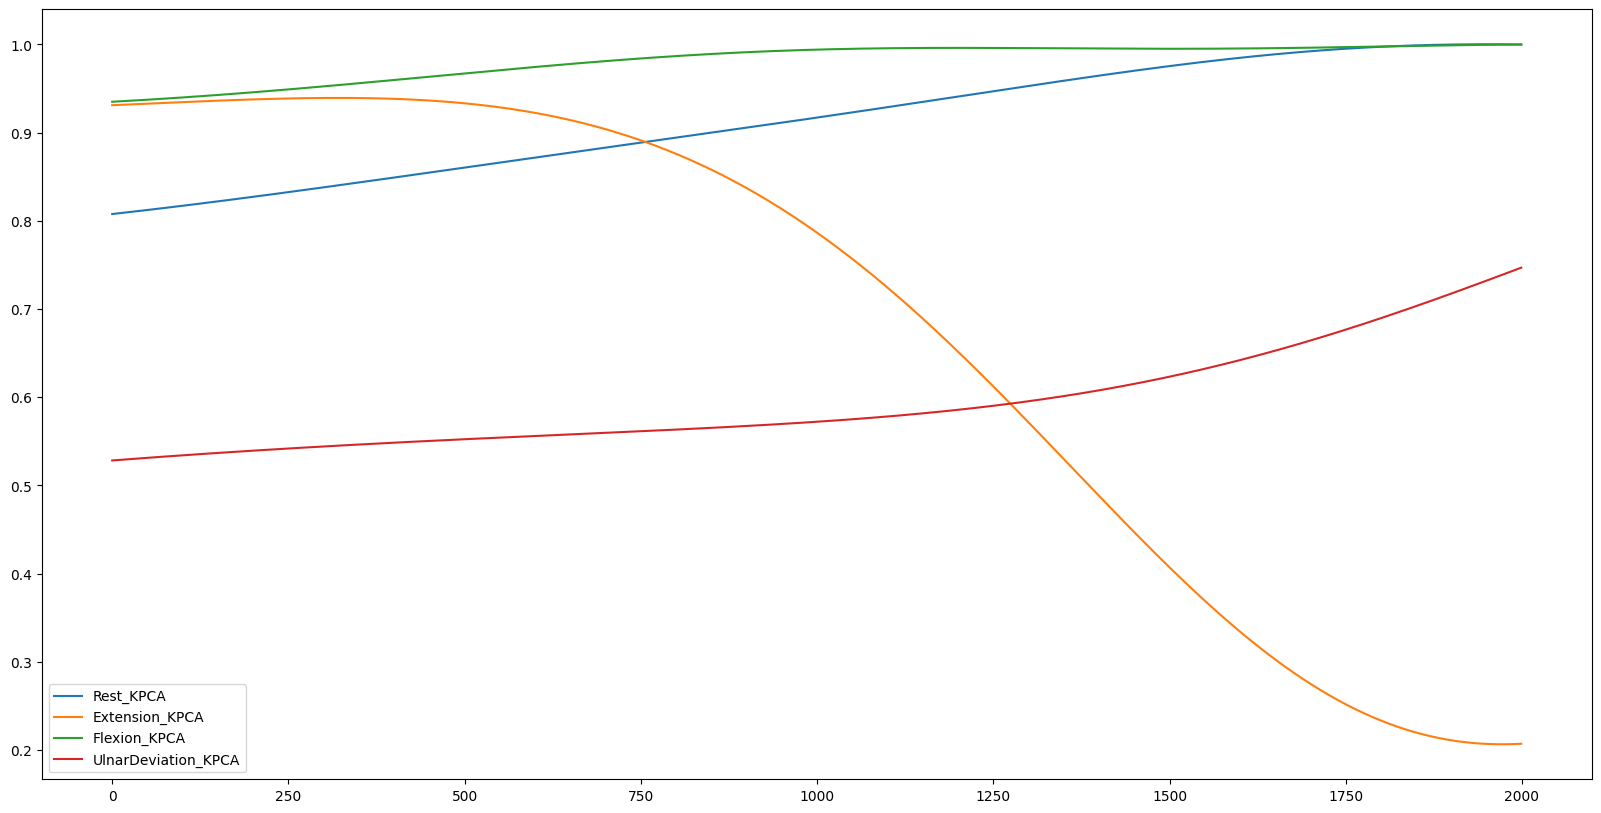

In [123]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=1, kernel='rbf')

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_kpca'.format(g)] = minmaxscaler.fit_transform(kpca.fit_transform(standardscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][80])))[500:2500]
    ax.plot(globals()['{}_kpca'.format(g)],label='{}_KPCA'.format(g))

plt.legend()
plt.show()

3. SparsePCA - a variant of PCA with the goal of reduced data can reconstruct the original data

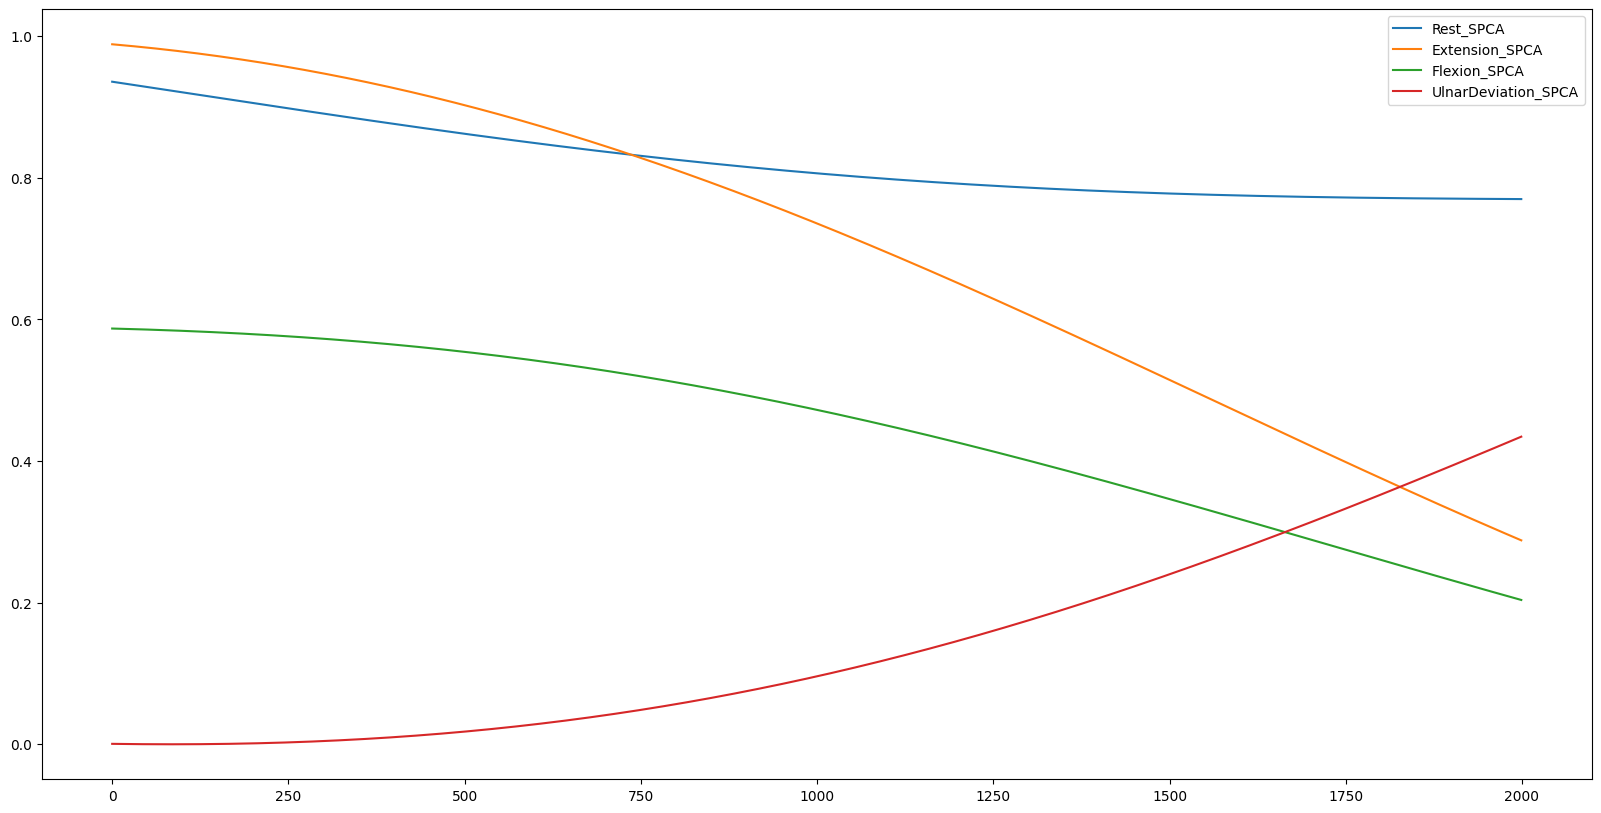

In [95]:
from sklearn.decomposition import SparsePCA
spca = SparsePCA(n_components=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_spca'.format(g)] = minmaxscaler.fit_transform(spca.fit_transform(standardscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][40])))[500:2500]
    ax.plot(globals()['{}_spca'.format(g)],label='{}_SPCA'.format(g))

plt.legend()
plt.show()

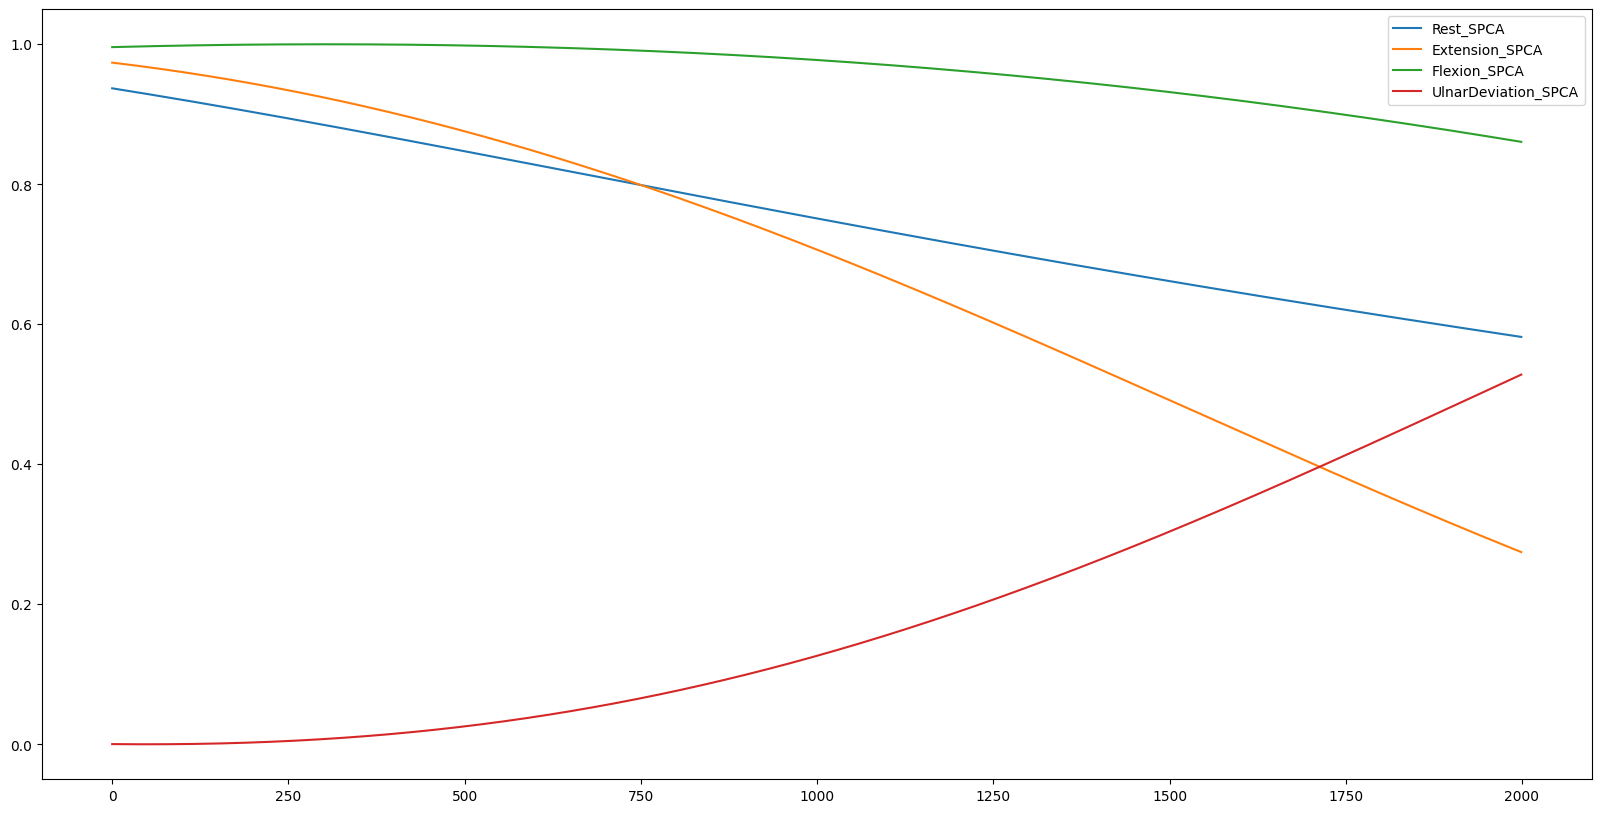

In [96]:
from sklearn.decomposition import SparsePCA
spca = SparsePCA(n_components=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_spca'.format(g)] = minmaxscaler.fit_transform(spca.fit_transform(standardscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][80])))[500:2500]
    ax.plot(globals()['{}_spca'.format(g)],label='{}_SPCA'.format(g))

plt.legend()
plt.show()

4. IncrementalPCA - low-rank approximation

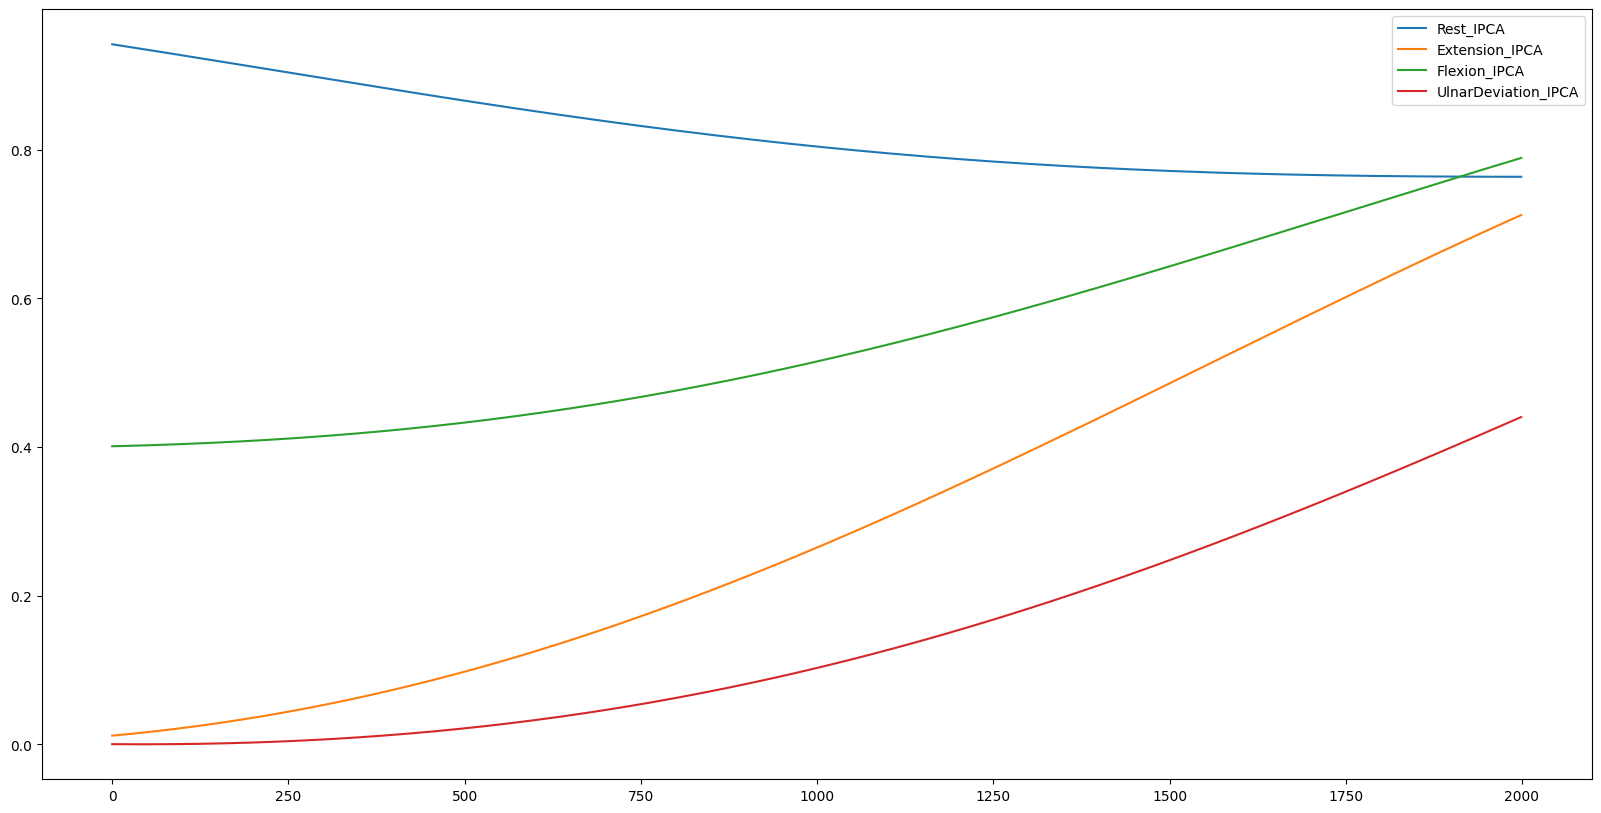

In [100]:
from sklearn.decomposition import IncrementalPCA
ipca = IncrementalPCA(n_components=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_ipca'.format(g)] = minmaxscaler.fit_transform(ipca.fit_transform(standardscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][40])))[500:2500]
    ax.plot(globals()['{}_ipca'.format(g)],label='{}_IPCA'.format(g))

plt.legend()
plt.show()

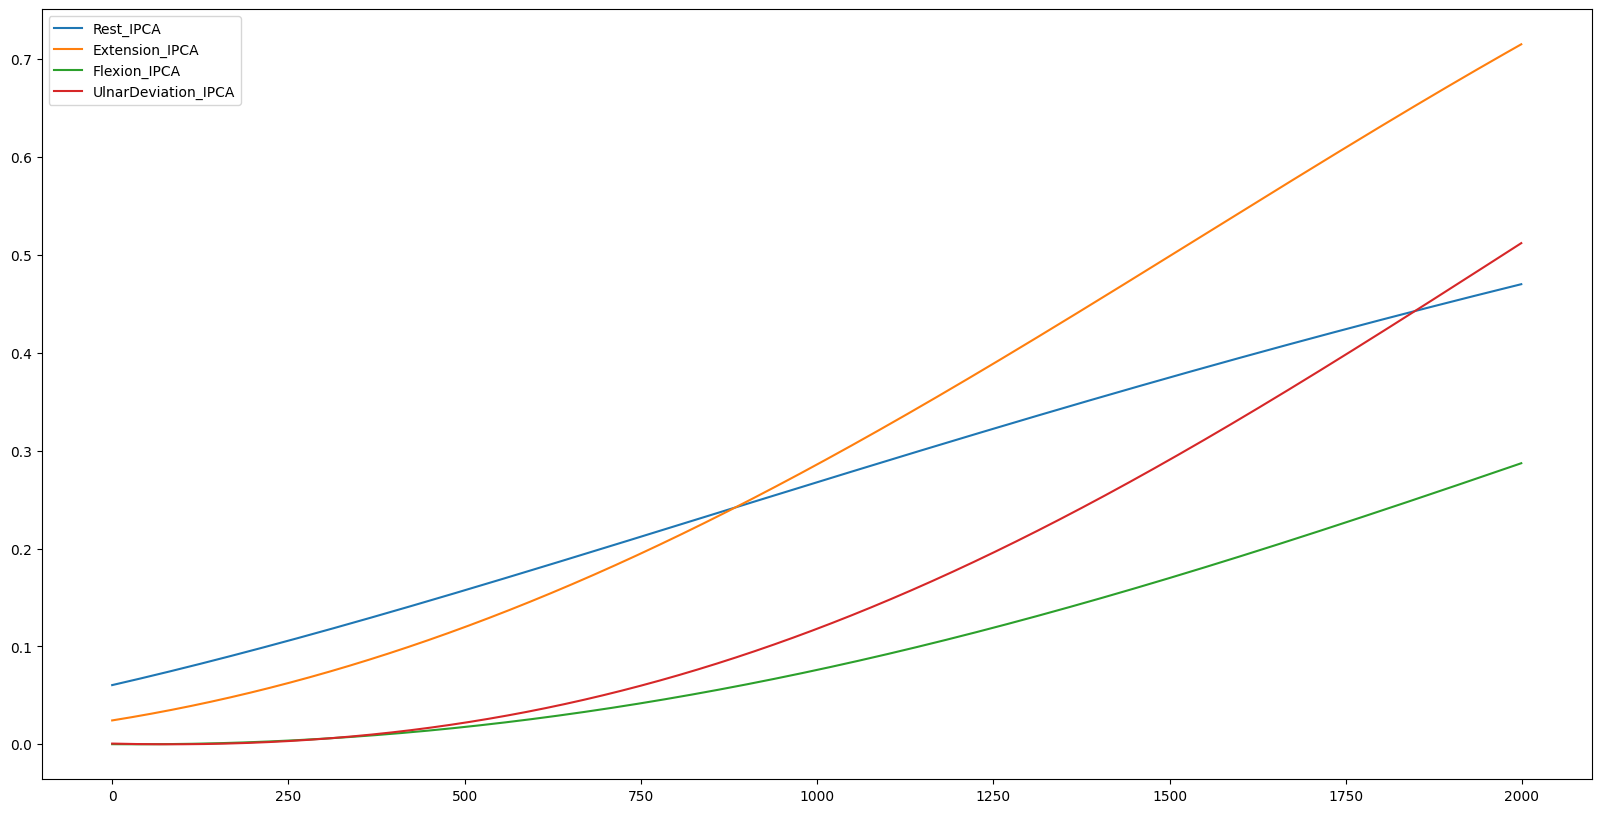

In [99]:
from sklearn.decomposition import IncrementalPCA
ipca = IncrementalPCA(n_components=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_ipca'.format(g)] = minmaxscaler.fit_transform(ipca.fit_transform(standardscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][80])))[500:2500]
    ax.plot(globals()['{}_ipca'.format(g)],label='{}_IPCA'.format(g))

plt.legend()
plt.show()

5. Fast ICA - Independent Componete Analysis

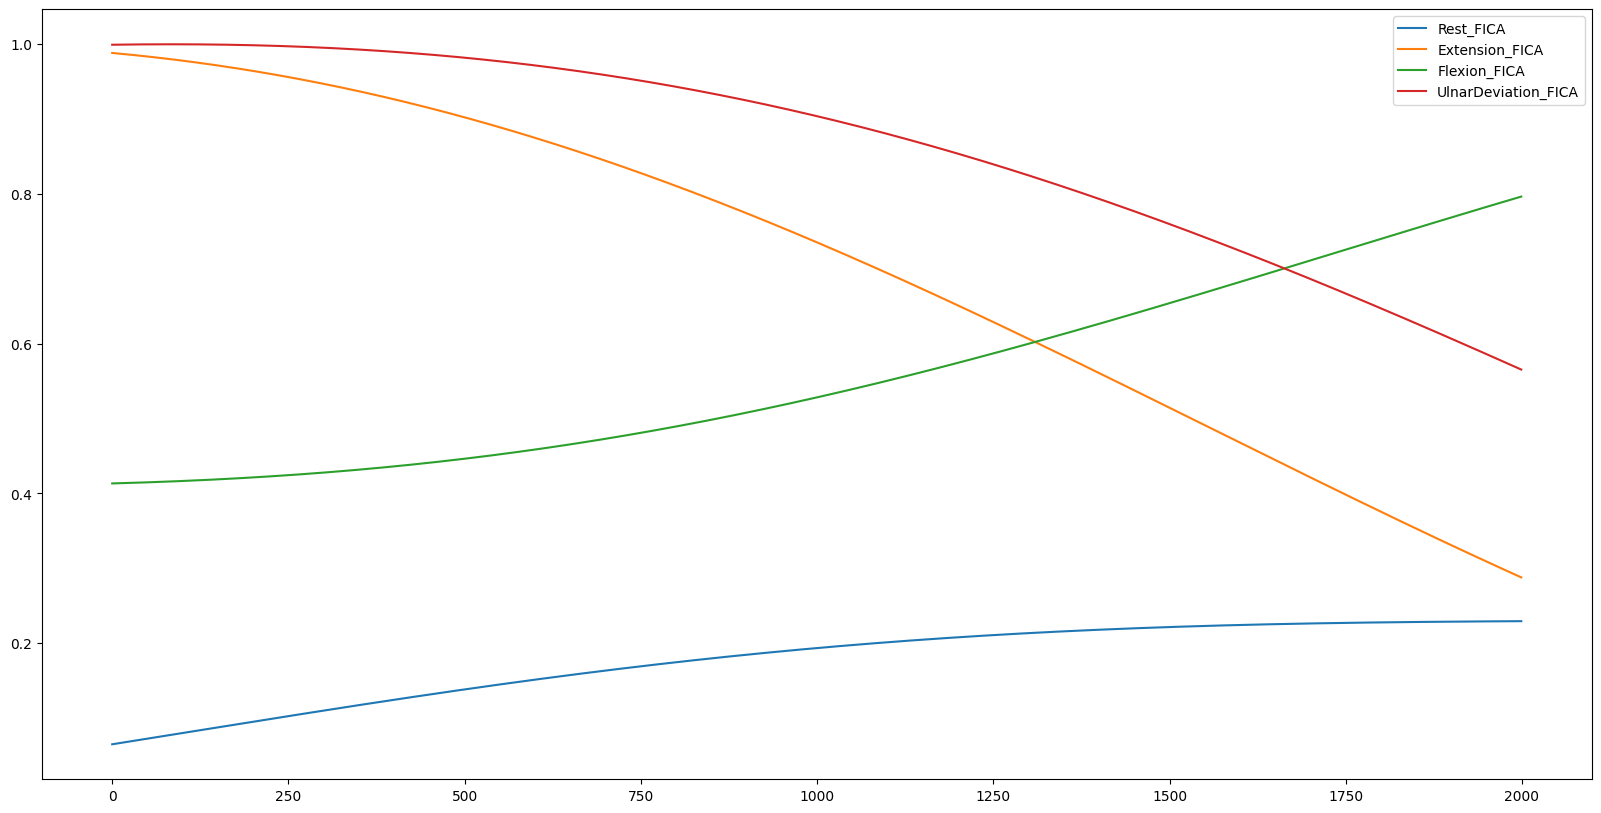

In [105]:
from sklearn.decomposition import FastICA

fica = FastICA(n_components=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_fica'.format(g)] = minmaxscaler.fit_transform(fica.fit_transform(standardscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][40])))[500:2500]
    ax.plot(globals()['{}_fica'.format(g)],label='{}_FICA'.format(g))

plt.legend()
plt.show()

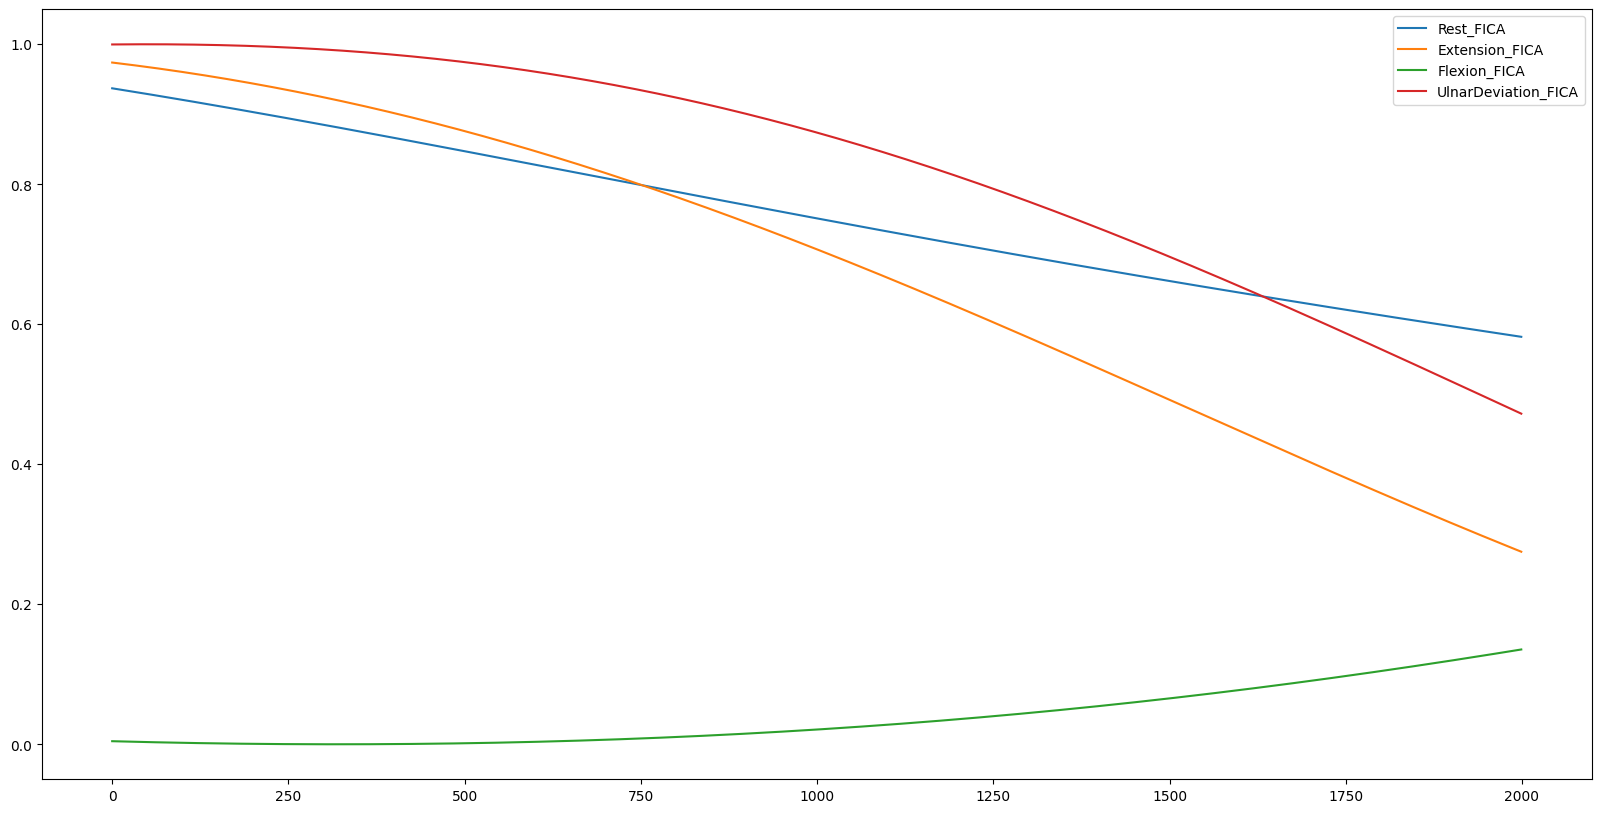

In [106]:
from sklearn.decomposition import FastICA

fica = FastICA(n_components=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_fica'.format(g)] = minmaxscaler.fit_transform(fica.fit_transform(standardscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][80])))[500:2500]
    ax.plot(globals()['{}_fica'.format(g)],label='{}_FICA'.format(g))

plt.legend()
plt.show()

6. NMF(Non-negative Matrix Factorizatiion) - unsupervied, breaks up original data into multiple matrices

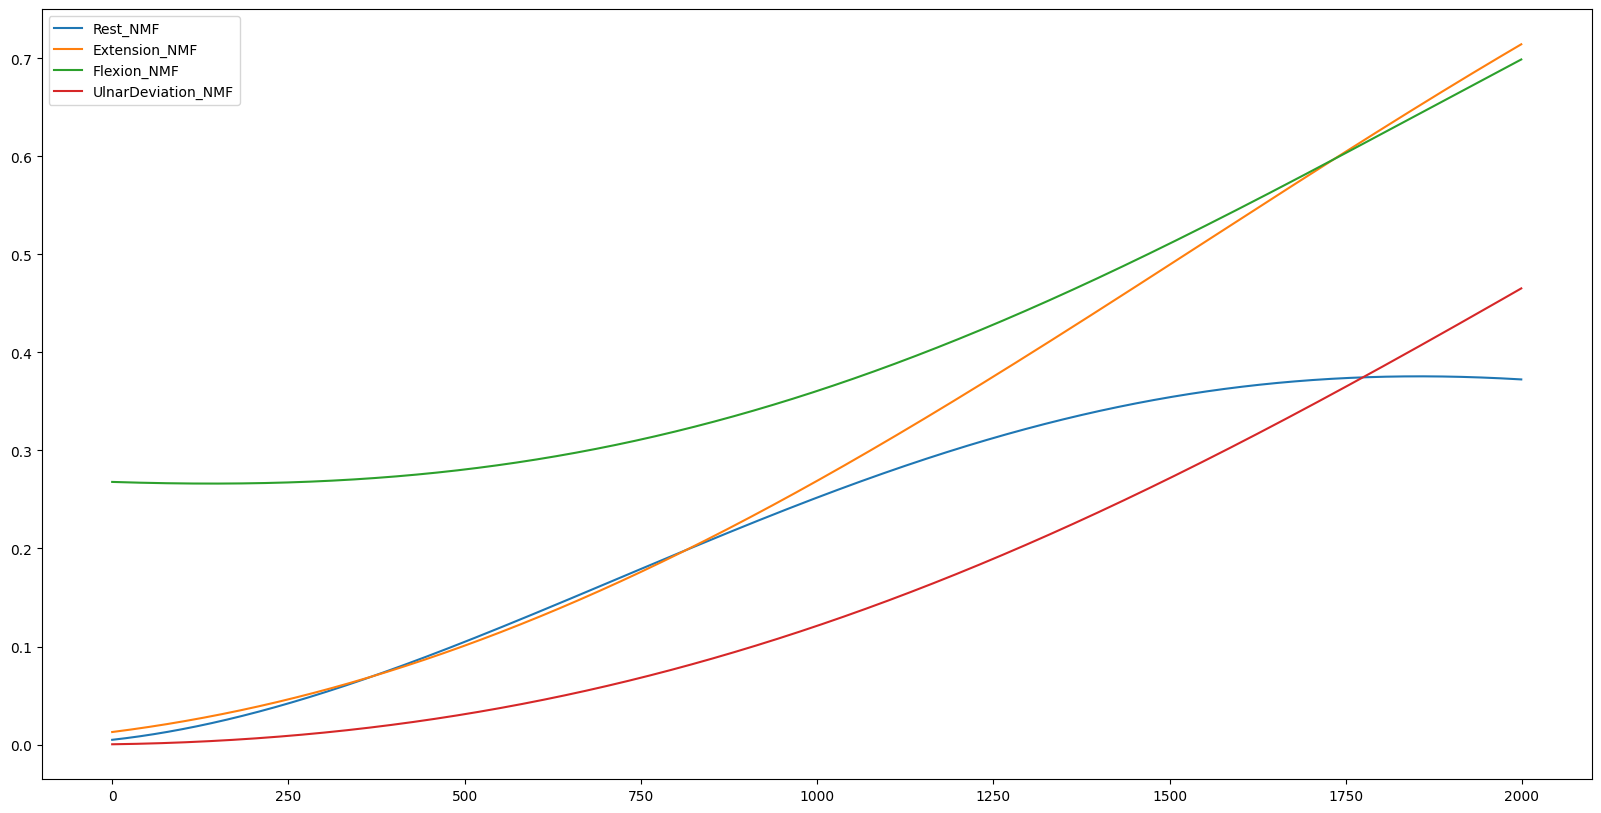

In [113]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=1, random_state=0,init='nndsvd',max_iter=10000)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_nmf'.format(g)] = minmaxscaler.fit_transform(nmf.fit_transform(minmaxscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][40])))[500:2500]
    ax.plot(globals()['{}_nmf'.format(g)],label='{}_NMF'.format(g))

plt.legend()
plt.show()

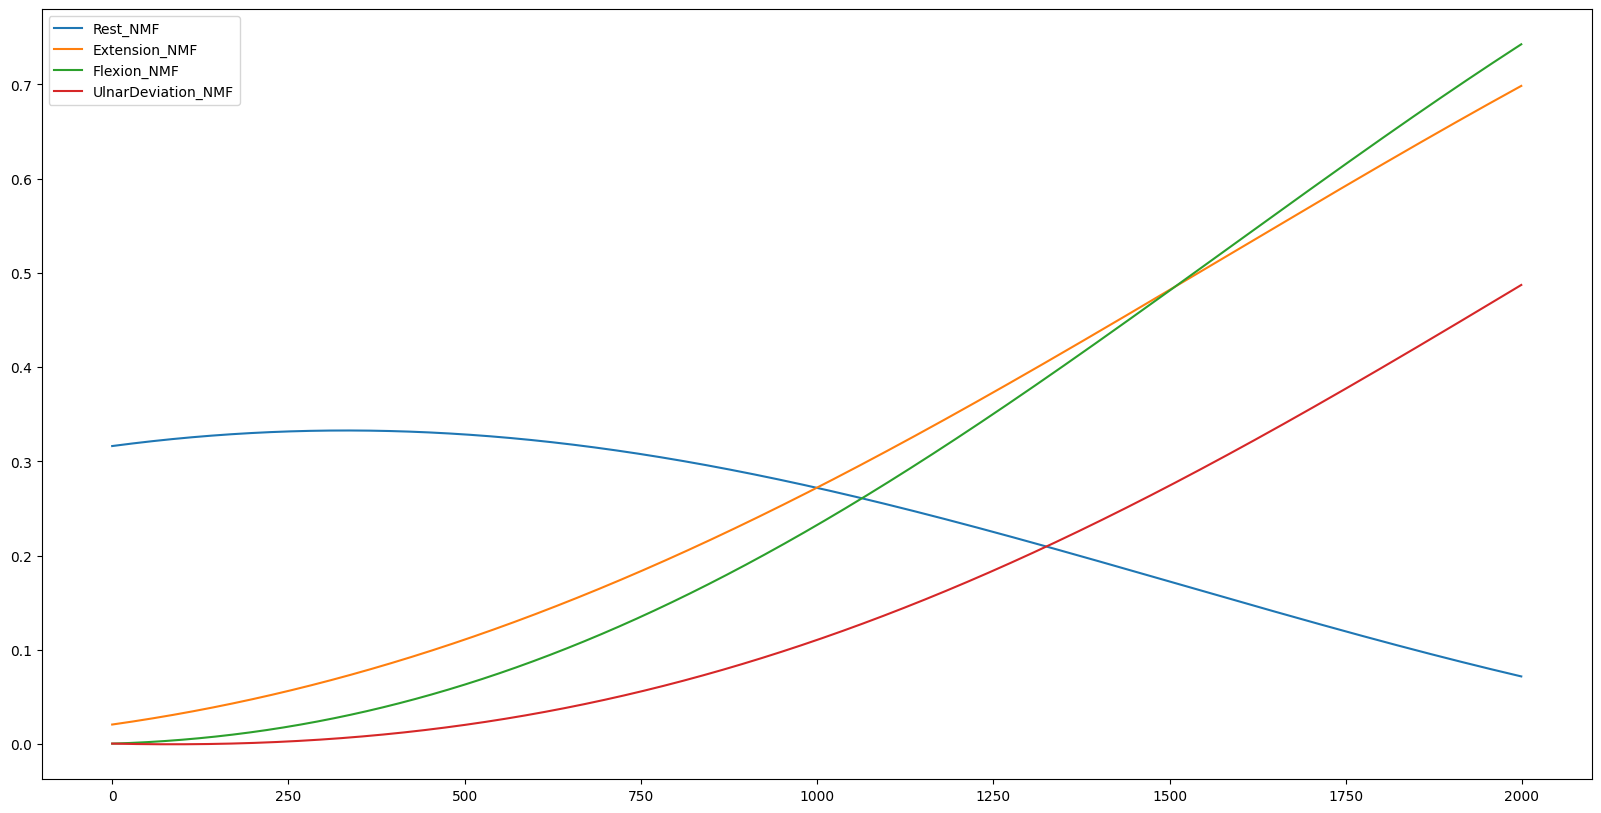

In [114]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=1, random_state=0,init='nndsvd',max_iter=10000)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_nmf'.format(g)] = minmaxscaler.fit_transform(nmf.fit_transform(minmaxscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][80])))[500:2500]
    ax.plot(globals()['{}_nmf'.format(g)],label='{}_NMF'.format(g))

plt.legend()
plt.show()

7. TSVD(Truncated Singular Value Decomposition) - performs linear dimensionality reduction by means of truncated SVD, contrary to PCA this does not center the data

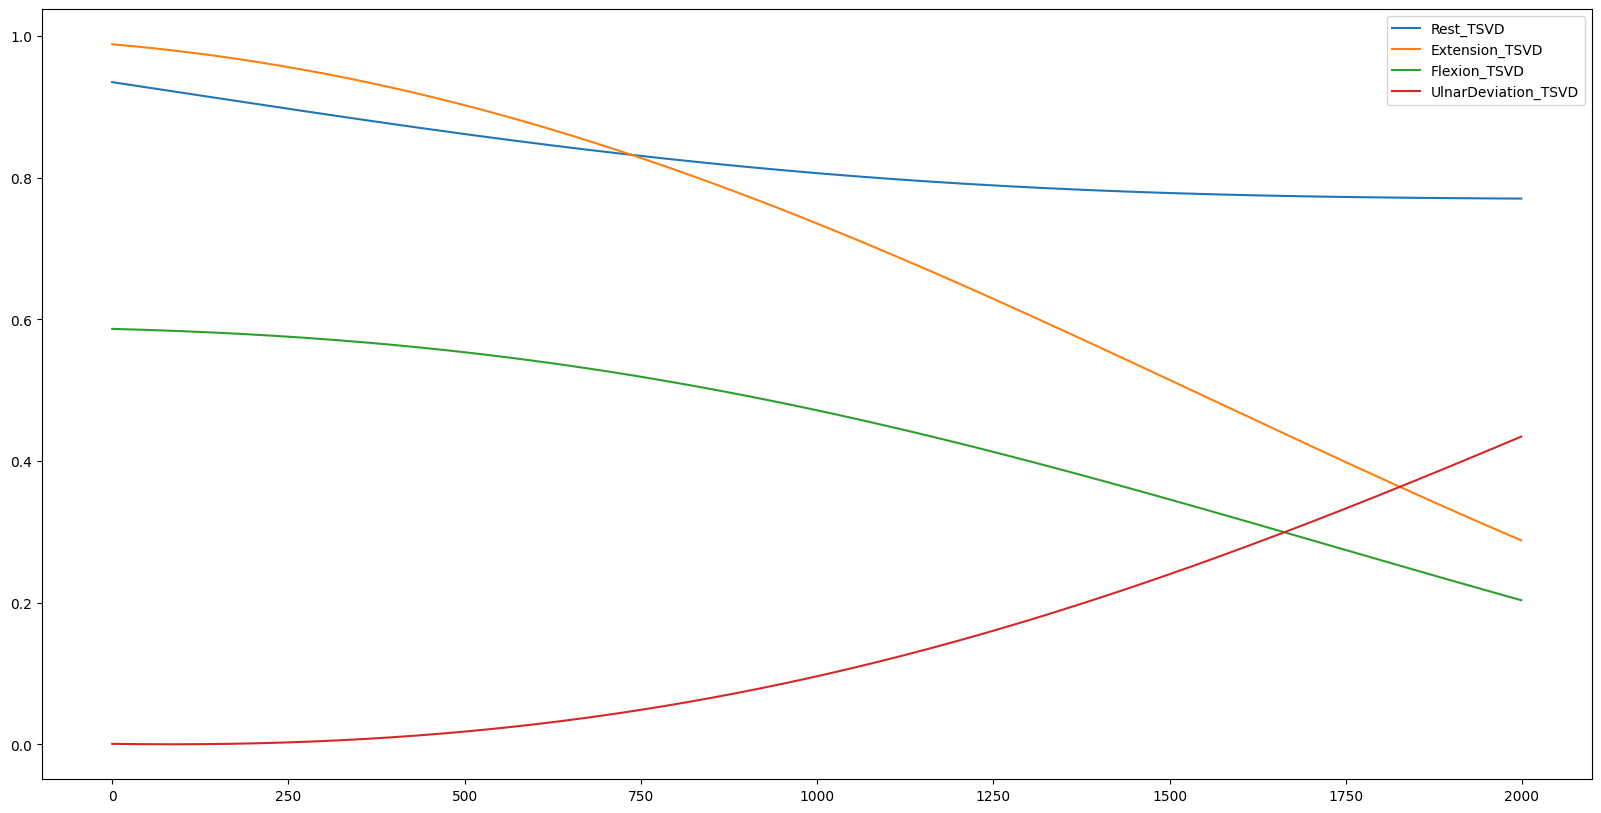

In [120]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_tsvd'.format(g)] = minmaxscaler.fit_transform(tsvd.fit_transform(standardscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][40])))[500:2500]
    ax.plot(globals()['{}_tsvd'.format(g)],label='{}_TSVD'.format(g))

plt.legend()
plt.show()

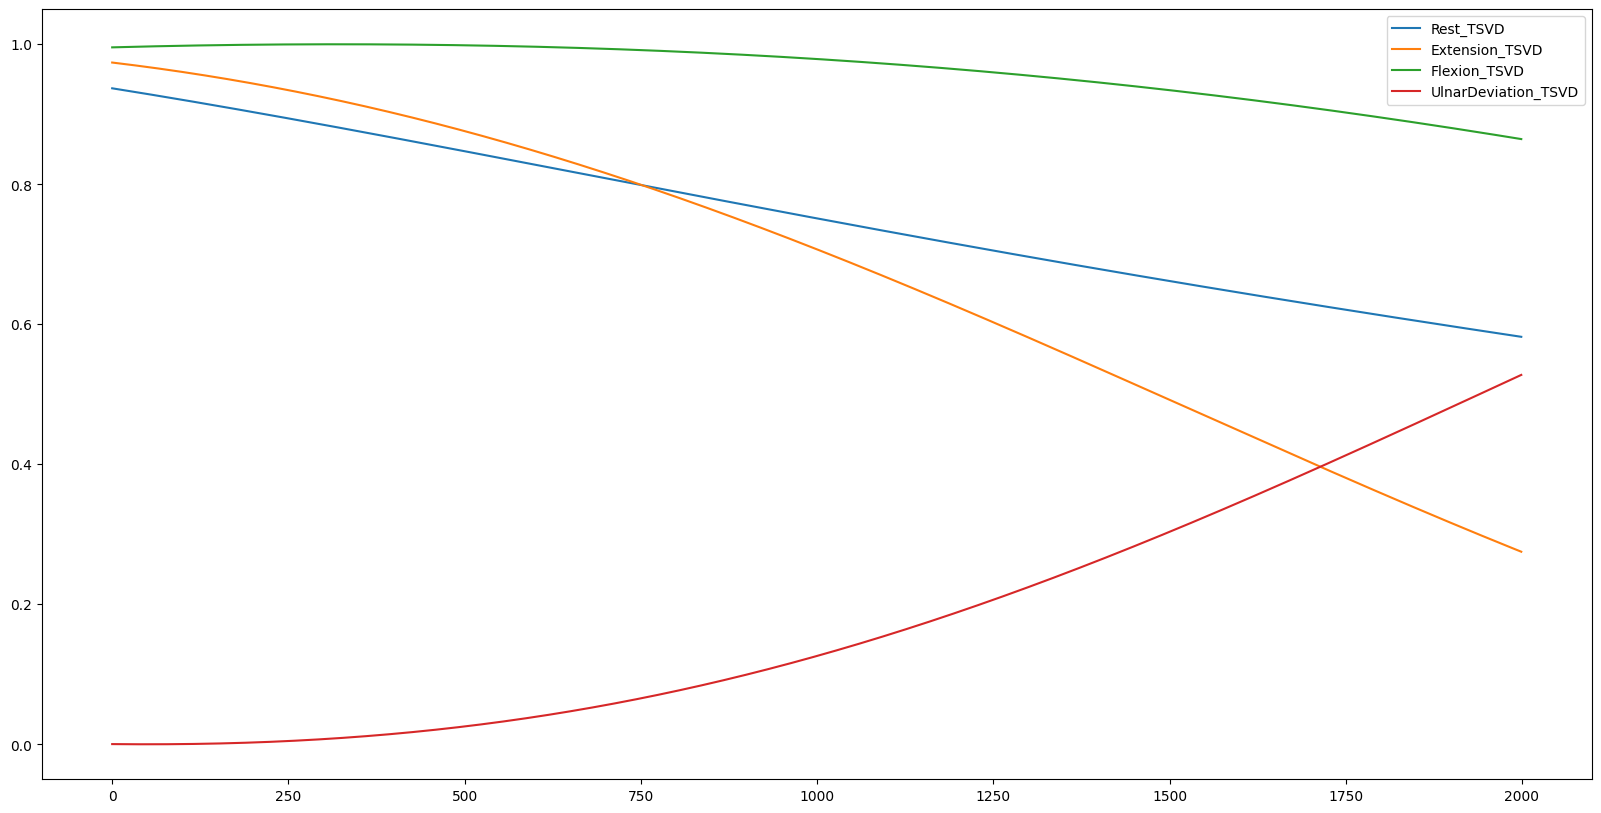

In [121]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_tsvd'.format(g)] = minmaxscaler.fit_transform(tsvd.fit_transform(standardscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][80])))[500:2500]
    ax.plot(globals()['{}_tsvd'.format(g)],label='{}_TSVD'.format(g))

plt.legend()
plt.show()

8. t-SNE(t-distributed Stochastic Neighbor Embedding) - calculate similarity between high dimensional data and low dimensional data and optimize (discrete)

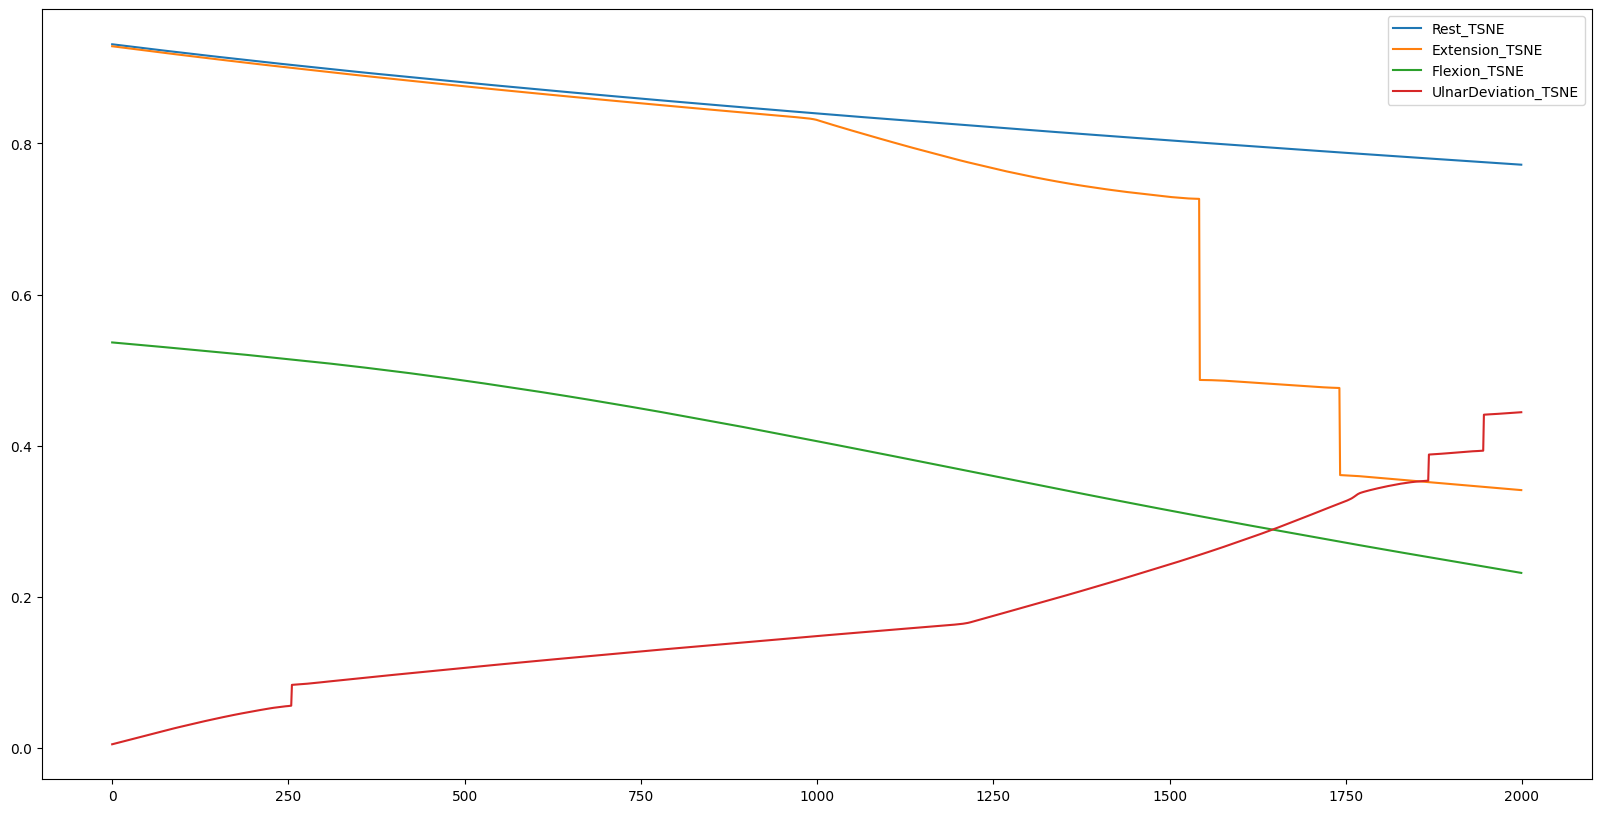

In [128]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_tsne'.format(g)] = minmaxscaler.fit_transform(tsne.fit_transform(standardscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][40])))[500:2500]
    ax.plot(globals()['{}_tsne'.format(g)],label='{}_TSNE'.format(g))

plt.legend()
plt.show()

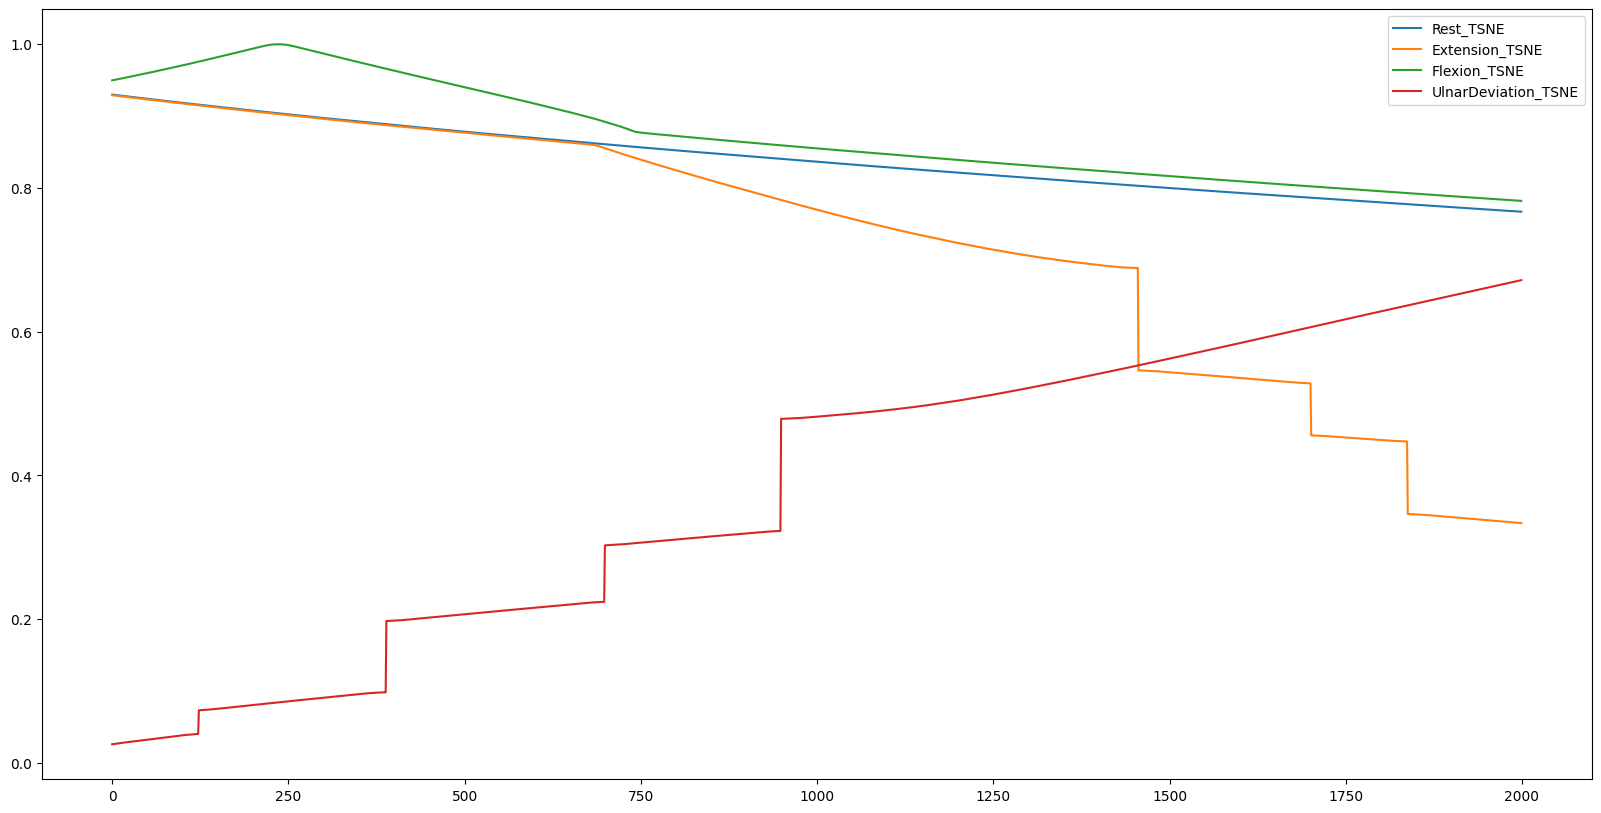

In [129]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_tsne'.format(g)] = minmaxscaler.fit_transform(tsne.fit_transform(standardscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][80])))[500:2500]
    ax.plot(globals()['{}_tsne'.format(g)],label='{}_TSNE'.format(g))

plt.legend()
plt.show()

9. Isomap - non-linear Isometric Mapping

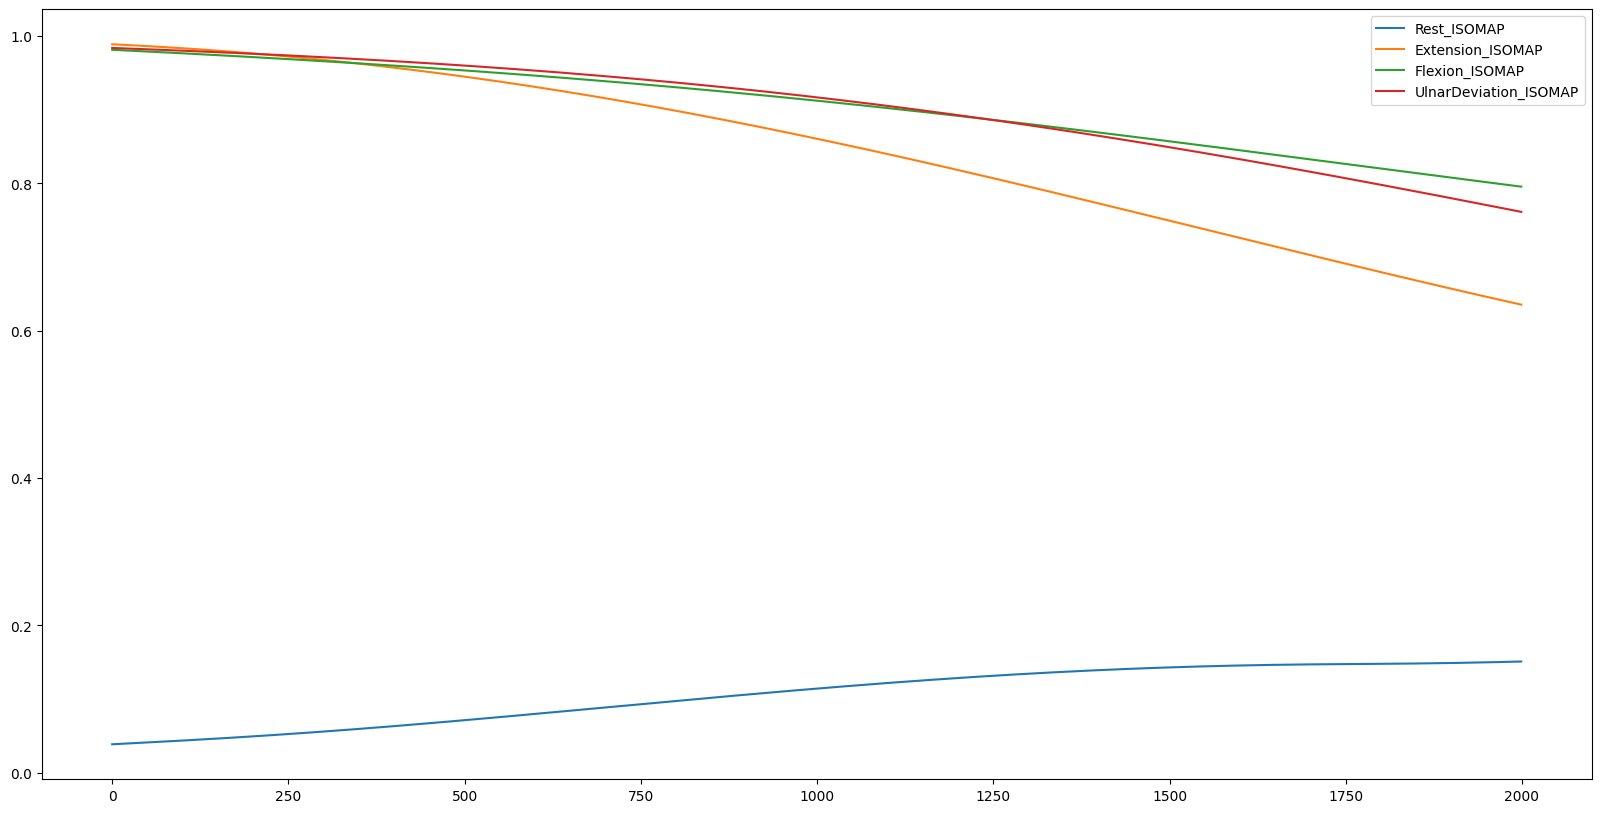

In [130]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_isomap'.format(g)] = minmaxscaler.fit_transform(isomap.fit_transform(standardscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][40])))[500:2500]
    ax.plot(globals()['{}_isomap'.format(g)],label='{}_ISOMAP'.format(g))

plt.legend()
plt.show()

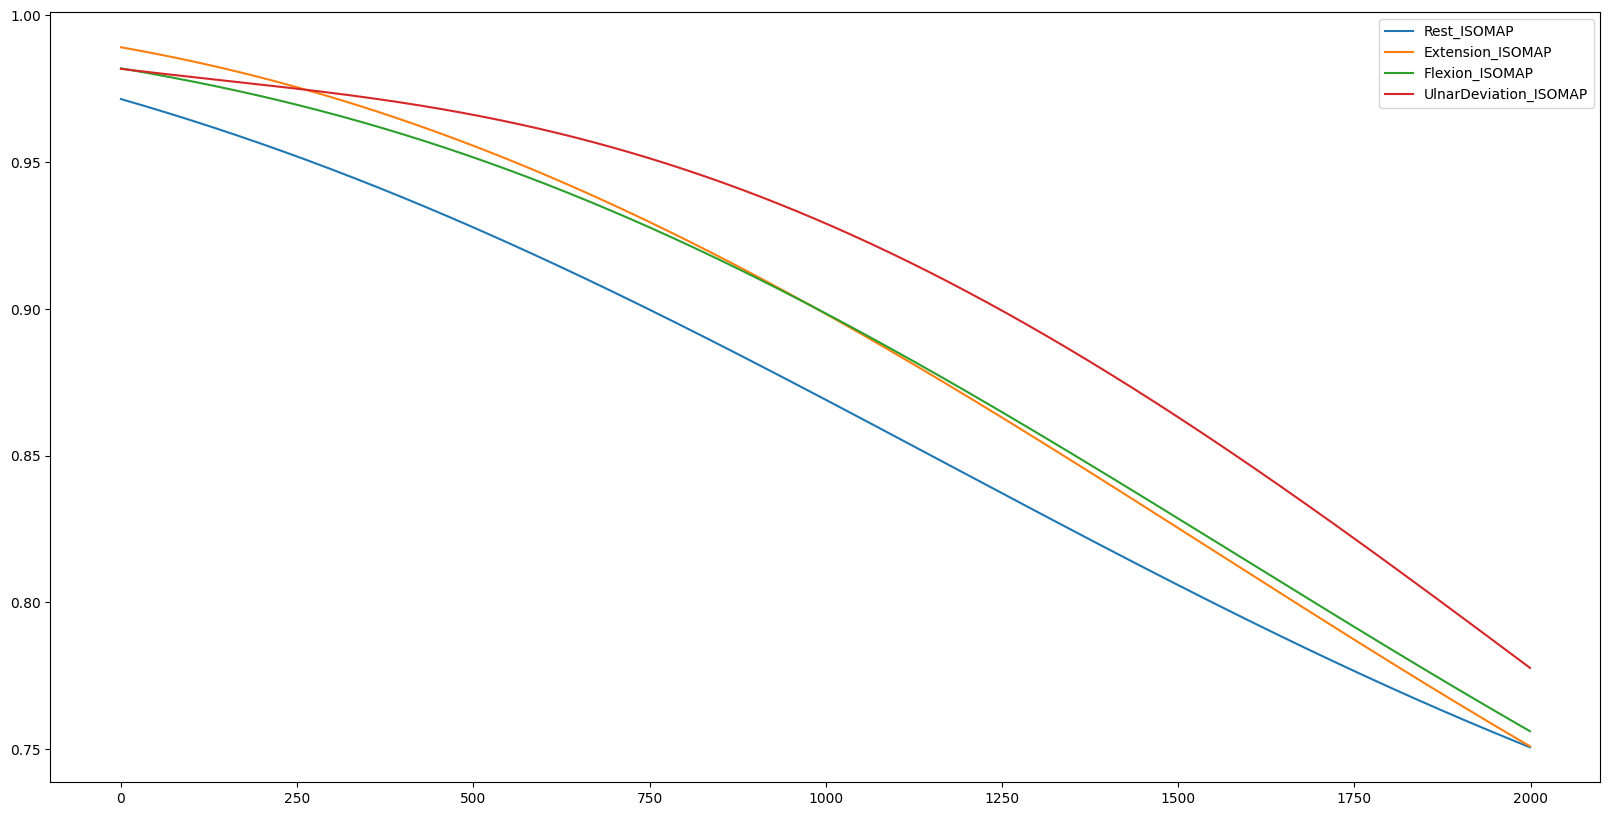

In [131]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    globals()['{}_isomap'.format(g)] = minmaxscaler.fit_transform(isomap.fit_transform(standardscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][80])))[500:2500]
    ax.plot(globals()['{}_isomap'.format(g)],label='{}_ISOMAP'.format(g))

plt.legend()
plt.show()

Define functions

In [172]:
def Gesture_Max(sig):
    std_sig = standardscaler.fit_transform(sig)
    sig_max = np.max(std_sig[4000:5000,])

    for i in range(4):
        if np.any(np.isin(std_sig[4000:5000,i],sig_max)) == True: # know which channel has the maximum value when the gesture is engaged
            cut_ind = np.where(std_sig[4000:5000,i]==sig_max)[0][0] + 4000
            return cut_ind
    
def Cut_Box(sig, cut_ind, cut_size):
    cut_sig = sig[cut_ind-int(cut_size/2):cut_ind+int(cut_size/2)]
    return cut_sig

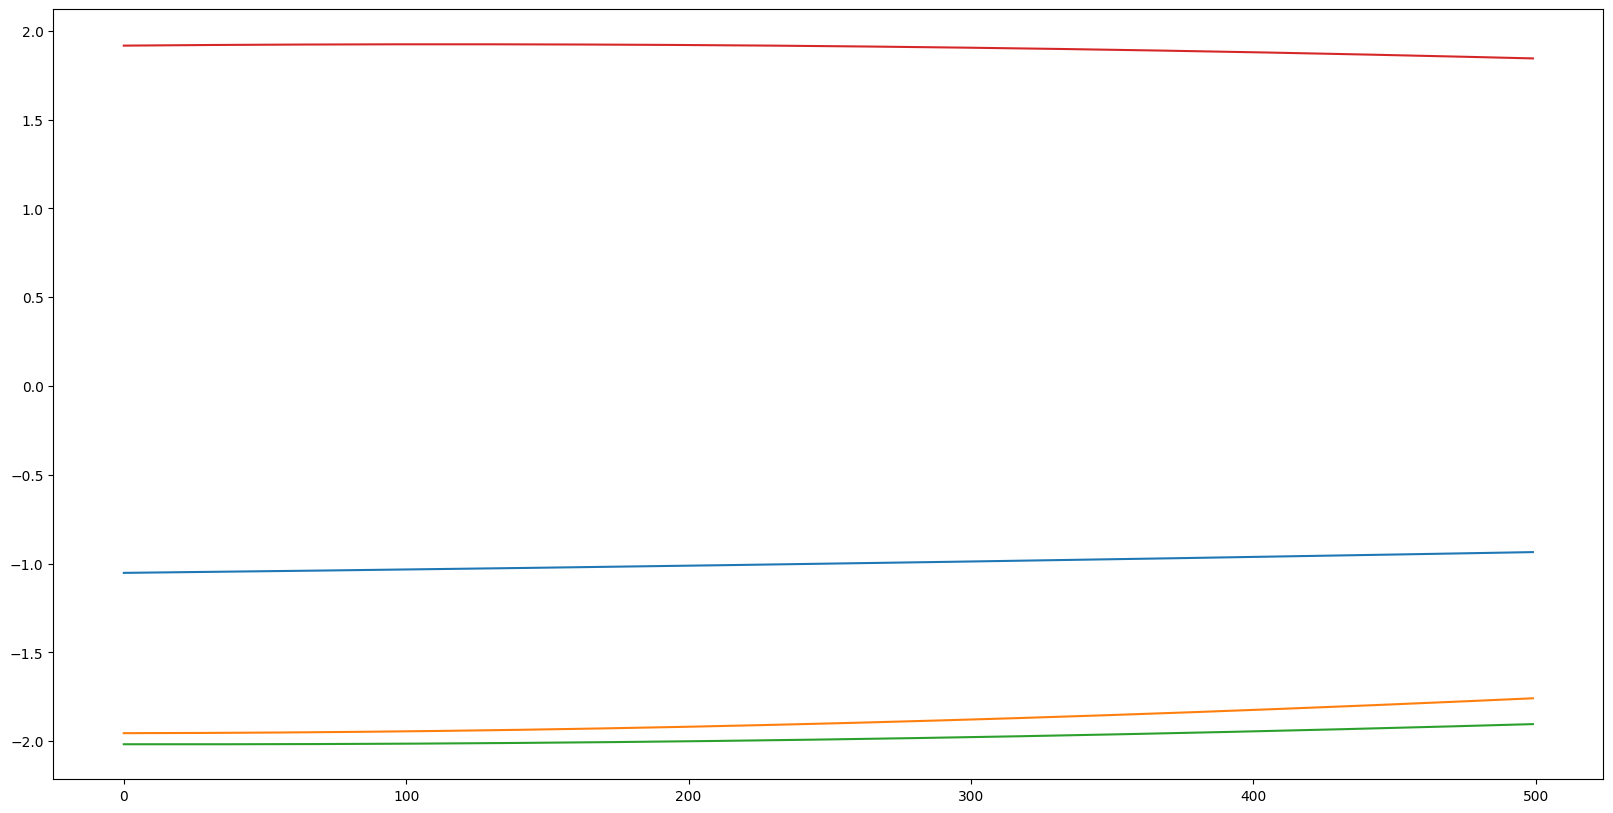

In [177]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    sig_filtered = globals()['{}_signal_filtered'.format(g)][40]
    globals()['{}_pca'.format(g)] = fica.fit_transform(minmaxscaler.fit_transform(standardscaler.fit_transform(sig_filtered)))
    sig_pca = globals()['{}_pca'.format(g)]
    cut_sig = Cut_Box(sig_pca, Gesture_Max(sig_filtered),500)

    ax.plot(cut_sig)

plt.show()


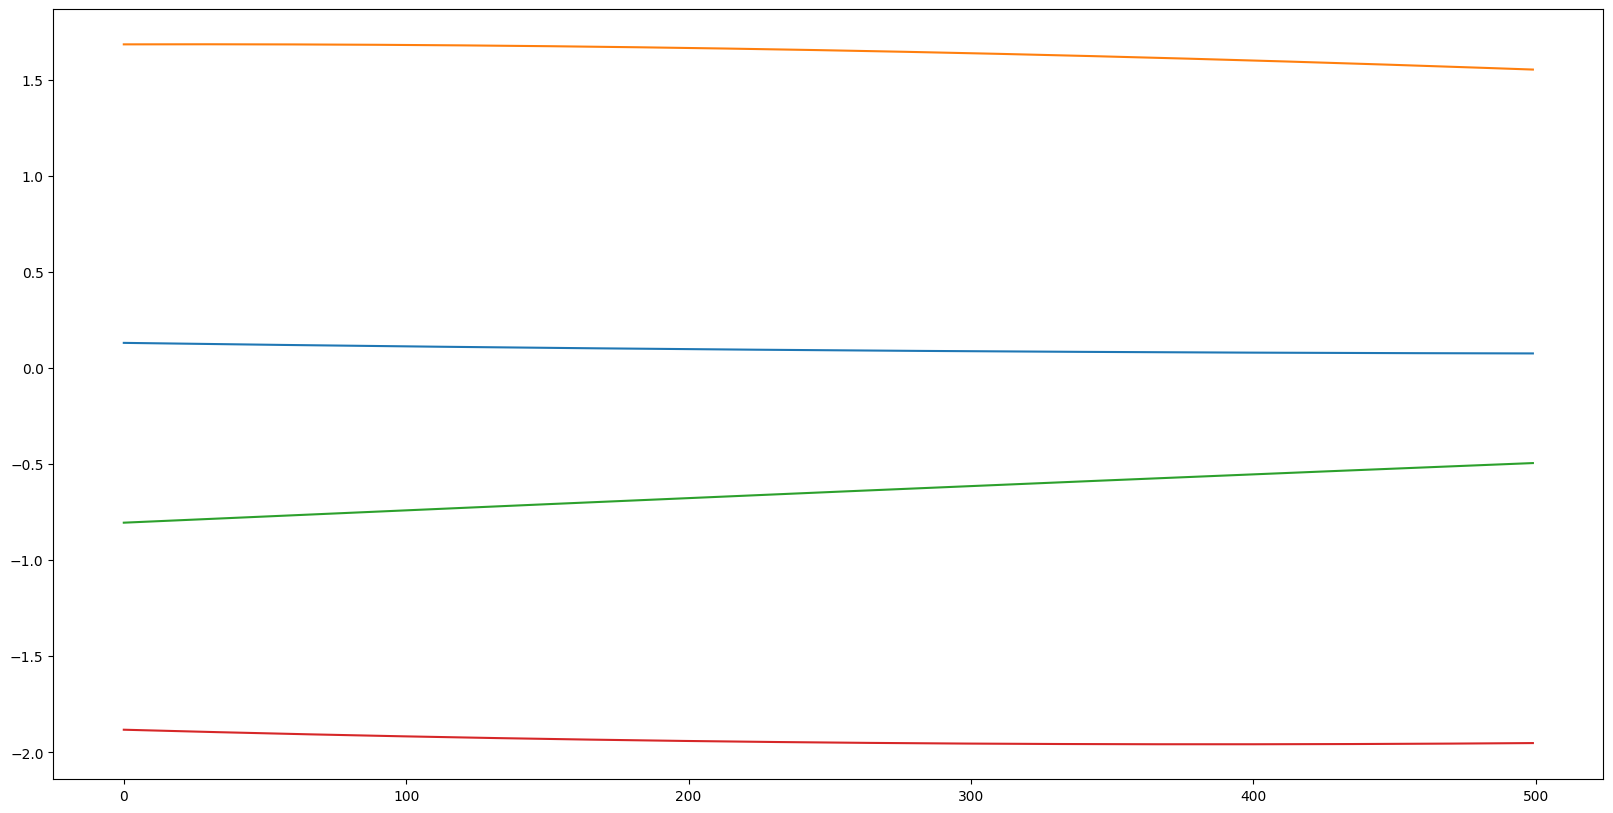

In [176]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for g in gesture_names[0:4]:
    sig_filtered = globals()['{}_signal_filtered'.format(g)][80]
    globals()['{}_pca'.format(g)] = fica.fit_transform(minmaxscaler.fit_transform(standardscaler.fit_transform(sig_filtered)))
    sig_pca = globals()['{}_pca'.format(g)]
    cut_sig = Cut_Box(sig_pca, Gesture_Max(sig_filtered),500)

    ax.plot(cut_sig)

plt.show()

Process all the data to fit model

In [23]:
for i in range(196): # 196(?) samples
    for g in gesture_names: # 10 gestures
        if i == 0:
            globals()['{}_processed'.format(g)] = np.zeros((globals()['{}_processed'.format(g)].shape[0],globals()['{}_processed'.format(g)].shape[1])) # make a 2-D array, columns are time and rows are classes
            globals()['{}_processed'.format(g)][i] = np.transpose(pca.fit_transform(minmaxscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][i]))) # apply MinMaxScaler and PCA to the data
                
        else:
            globals()['{}_processed'.format(g)][i] = np.transpose(pca.fit_transform(minmaxscaler.fit_transform(globals()['{}_signal_filtered'.format(g)][i]))) # apply MinMaxScaler and PCA to the data    

KeyError: 'Rest_processed'

NameError: name 'Flexion_processed' is not defined

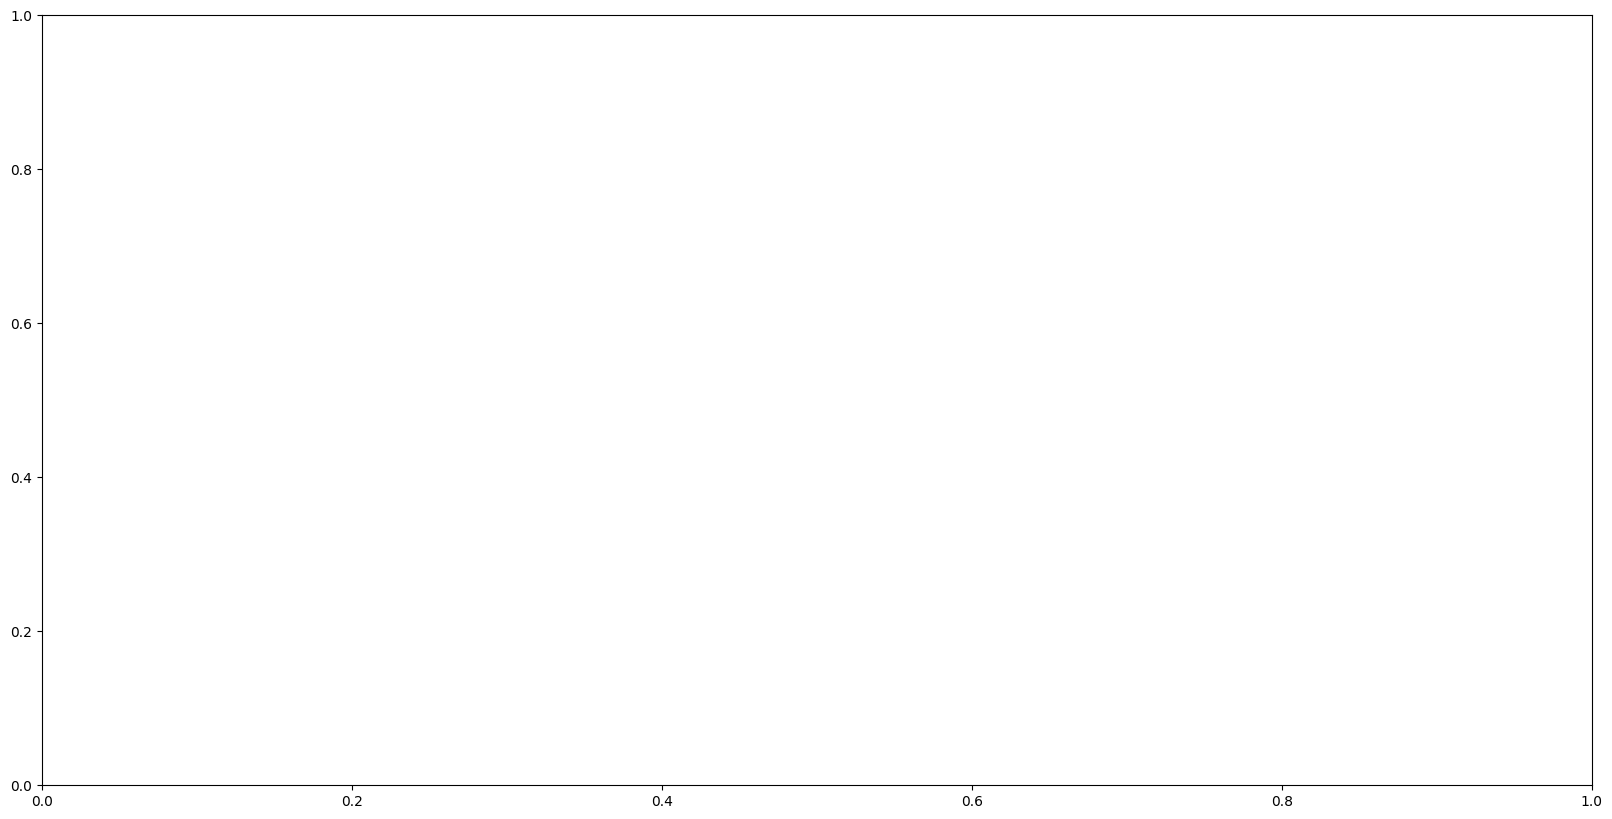

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(Flexion_processed[90],label='90th')
ax.plot(Extension_processed[120],label='120th')

plt.legend()
plt.show()

 TSF(Time Series Forest) - Classification

In [ ]:
from sktime.classification.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X, y = Extension_processed, np.array(range(Extension_processed.shape[0]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classifier = TimeSeriesForestClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.0

In [ ]:
classification_report(y_test, y_pred,output_dict=False)

'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       0.0\n           5       0.00      0.00      0.00       1.0\n           7       0.00      0.00      0.00       0.0\n           9       0.00      0.00      0.00       1.0\n          11       0.00      0.00      0.00       0.0\n          12       0.00      0.00      0.00       1.0\n          13       0.00      0.00      0.00       0.0\n          15       0.00      0.00      0.00       1.0\n          16       0.00      0.00      0.00       1.0\n          18       0.00      0.00      0.00       1.0\n          19       0.00      0.00      0.00       1.0\n          23       0.00      0.00      0.00       0.0\n          24       0.00      0.00      0.00       1.0\n          26       0.00      0.00      0.00       0.0\n          28       0.00      0.00      0.00       0.0\n          29       0.00      0.00      0.00       1.0\n          30       0.00      0.00      0.00       1.0\n       

    SAD

In [ ]:
"""
for i in range(40): #data1 to data40
    globals()['data{}'.format(i+1)] = pd.read_csv('/Users/jhr/workspace/GitHub/EMG_data_analysis/Dataset for multi-channel surface electromyography (sEMG) signals of hand gestures/sEMG-dataset/raw/csv/{}_raw.csv'.format(i+1), names=col_names)

    globals()['data{}_pattern'.format(i+1)] = [globals()['data{}'.format(i+1)][r:r + 268000] for r in range(0, len(globals()['data{}'.format(i+1)]), 268000)] #divide the data by 268000 steps at a time

    for f in col_names: #ch1 to ch4
        
        for j in range(5): #pattern1 to pattern5
            
            for g in range(10): #gesture1 to gesture10
                if g == 0: #make a dataframe what sets the standard index
                    globals()['data{}_gestures{}'.format(i+1,j+1)] = np.array_split(globals()['data{}_pattern'.format(i+1)][j].iloc[4000:204000], 10) #split the data into 10 gestures
                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)] = pd.DataFrame(globals()['data{}_gestures{}'.format(i+1,j+1)][g][f]) #new dataframe to set columns as gestures

                else: #appending the other features by pd.concat
                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)] = pd.concat([globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)],pd.DataFrame(globals()['data{}_gestures{}'.format(i+1,j+1)][g][f]).set_index(globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].index)],axis=1,join='inner')
                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].reset_index(drop=True, inplace=True) #reset the index

                    globals()['data{}_{}_gestures{}_litre'.format(i+1,f,j+1)] = globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].iloc[3000:17000] #new dataframe with a little of the rest time(0:4000, 16000:20000)
                    globals()['data{}_{}_gestures{}_litre'.format(i+1,f,j+1)].reset_index(drop=True, inplace=True) #reset the index
            
            globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].columns = gesture_names #rename the columns by the exact gesture names
            globals()['data{}_{}_gestures{}_litre'.format(i+1,f,j+1)].columns = gesture_names #rename the columns by the exact gesture names
"""

"\nfor i in range(40): #data1 to data40\n    globals()['data{}'.format(i+1)] = pd.read_csv('/Users/jhr/workspace/GitHub/EMG_data_analysis/Dataset for multi-channel surface electromyography (sEMG) signals of hand gestures/sEMG-dataset/raw/csv/{}_raw.csv'.format(i+1), names=col_names)\n\n    globals()['data{}_pattern'.format(i+1)] = [globals()['data{}'.format(i+1)][r:r + 268000] for r in range(0, len(globals()['data{}'.format(i+1)]), 268000)] #divide the data by 268000 steps at a time\n\n    for f in col_names: #ch1 to ch4\n        \n        for j in range(5): #pattern1 to pattern5\n            \n            for g in range(10): #gesture1 to gesture10\n                if g == 0: #make a dataframe what sets the standard index\n                    globals()['data{}_gestures{}'.format(i+1,j+1)] = np.array_split(globals()['data{}_pattern'.format(i+1)][j].iloc[4000:204000], 10) #split the data into 10 gestures\n                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)] = pd.DataFr

In [ ]:
"""
#Remove 'Ulnar Deviation', 'Radial Deviation', 'Abduction of Fingers', 'Adduction of Fingers' (no remarkable signal characteristic between two similar)
for i in range(40):
    for j in range(4):
        for k in range(5):
            globals()['data{}_ch{}_gestures{}_litre'.format(i+1,j+1,k+1)].drop(columns=['Ulnar Deviation', 'Radial Deviation', 'Abduction of Fingers', 'Adduction of Fingers'], inplace=True)
"""

"\nfor i in range(40):\n    for j in range(4):\n        for k in range(5):\n            globals()['data{}_ch{}_gestures{}_litre'.format(i+1,j+1,k+1)].drop(columns=['Ulnar Deviation', 'Radial Deviation', 'Abduction of Fingers', 'Adduction of Fingers'], inplace=True)\n"